In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2
%matplotlib inline

import copy
import csv
import logging
import os
from collections import Counter

import numpy as np
# import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from scipy.cluster.vq import kmeans2
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torchsummary import summary

import semg_bss

# Configure log file
LOG_FILE = "semg_bss.log"
logging.basicConfig(filename=LOG_FILE, encoding='utf-8', level=logging.INFO, filemode="w")

# Configure plot
# sns.set_theme(style="whitegrid", font_scale=2)

# Path to dataset
DATA_DIR = "./biowolf_data"

# Parameters to set
FS_EMG = 4000  # sampling frequency
MAX_COMP = 60  # target number of components
ORDERING = None  # "firing-rate", "neg-entropy" or None for recalibration
LOAD_SAVED_MODELS = False
SEED = 42

# Check CUDA
if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("CUDA acceleration available and enabled.")
else:
    dev = torch.device("cpu")
    print("CUDA acceleration not available.")

CUDA acceleration available and enabled.


# Decomposition of sEMG Signals and Gesture Classification
The aim of this project is to decompose a sEMG signal of a gesture, obtain the MUAPs, and then classify the gesture. In particular, we'll train the decomposition model once on a training signal, which must be sufficiently informative about the gesture we want to recognize (*offline calibration*). Then, we'll reuse the decomposition model to transform new signals and classify them (*online analysis*).

## 1. Data preprocessing
Let's load the raw signals (divided in 2 chunks) obtained with the BioWolf and plot it.

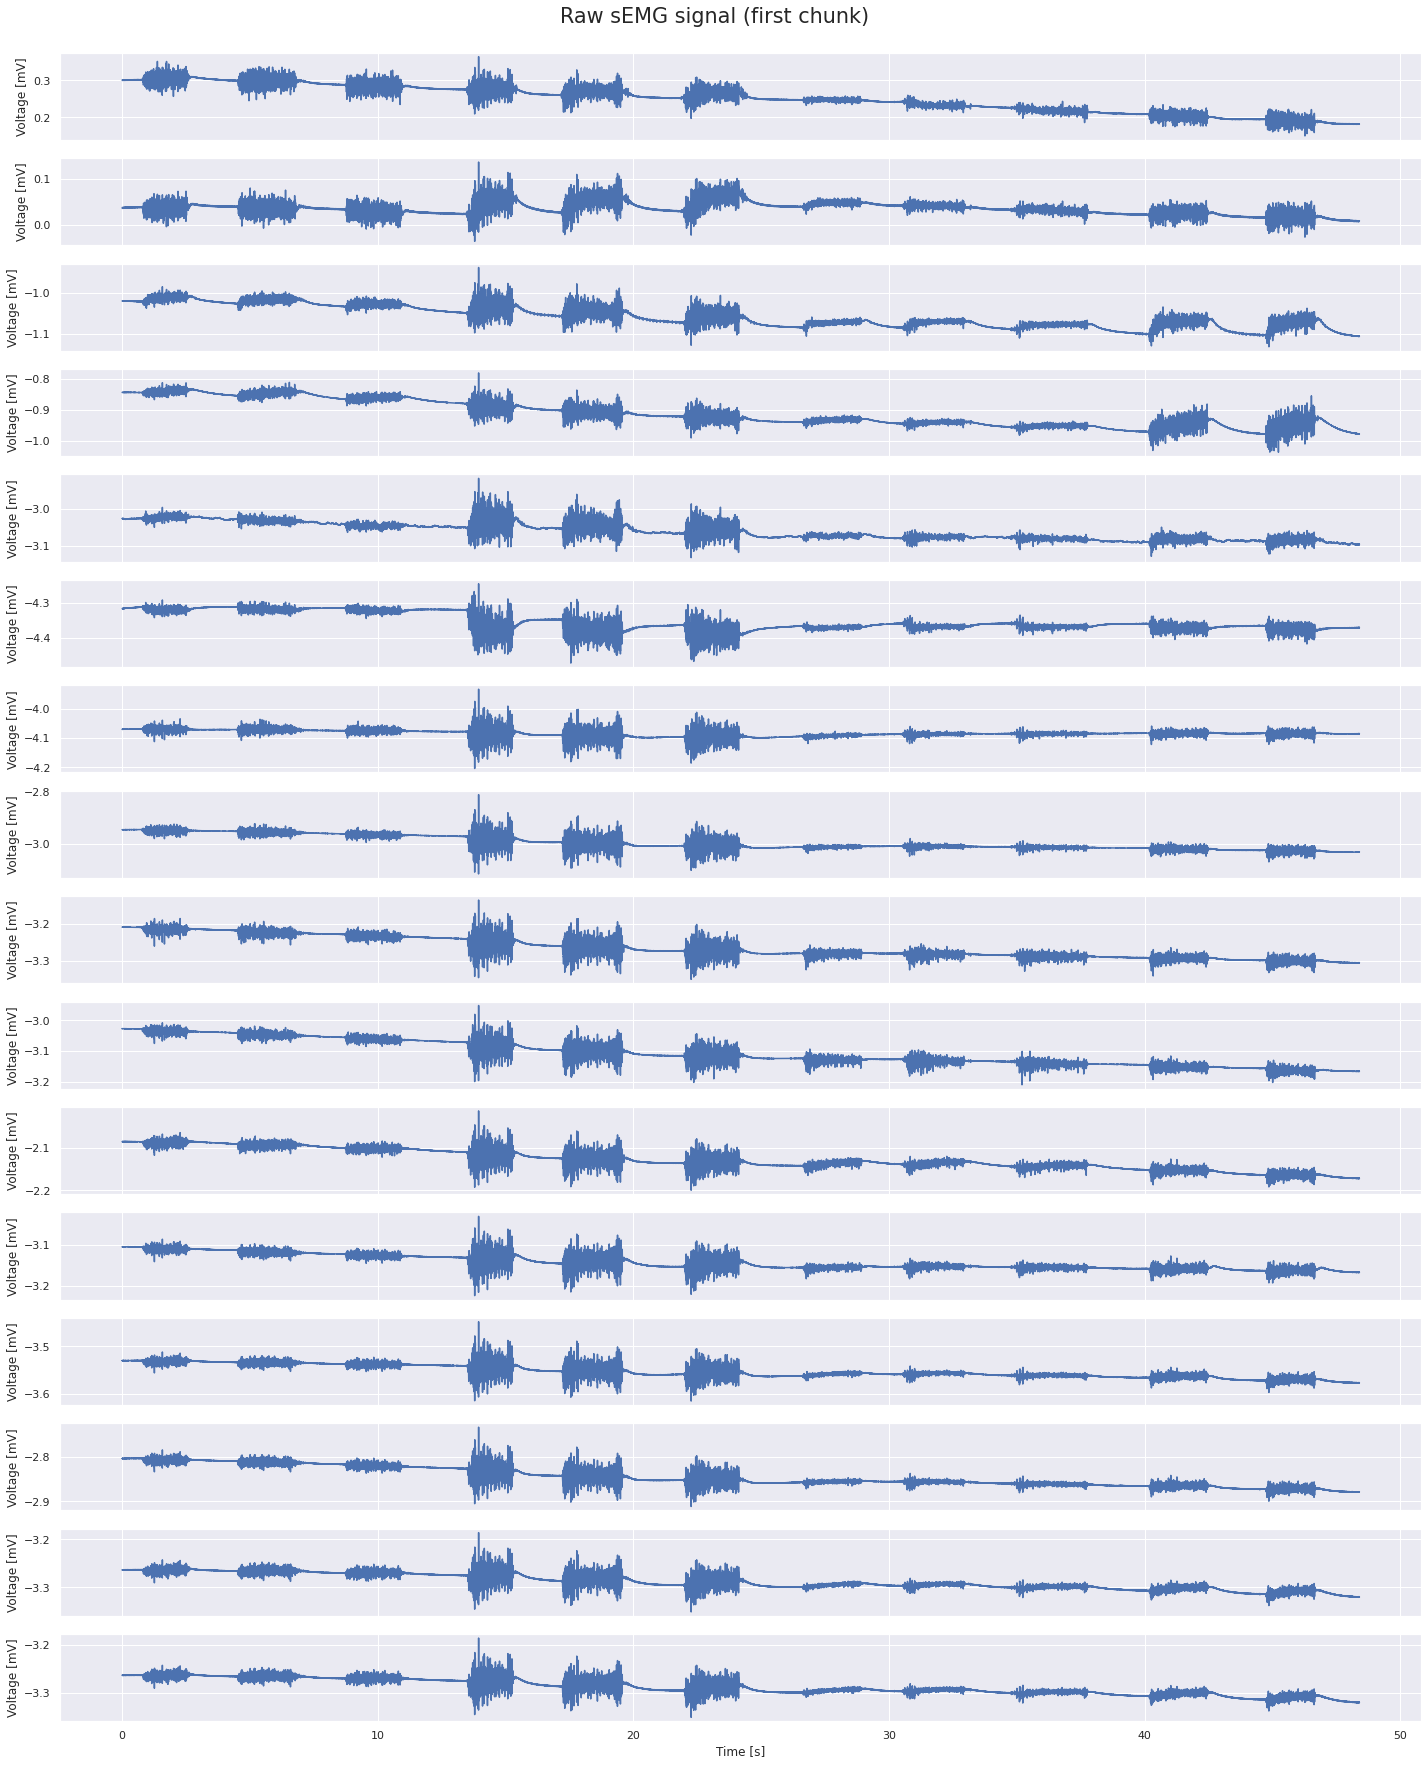

In [2]:
emg1 = semg_bss.datasets.biowolf.load_biowolf(DATA_DIR, n_sig=1)

semg_bss.plt.plot_signal(
    emg1,
    fs=FS_EMG,
    title="Raw sEMG signal (first chunk)",
    fig_size=(20, 25)
)

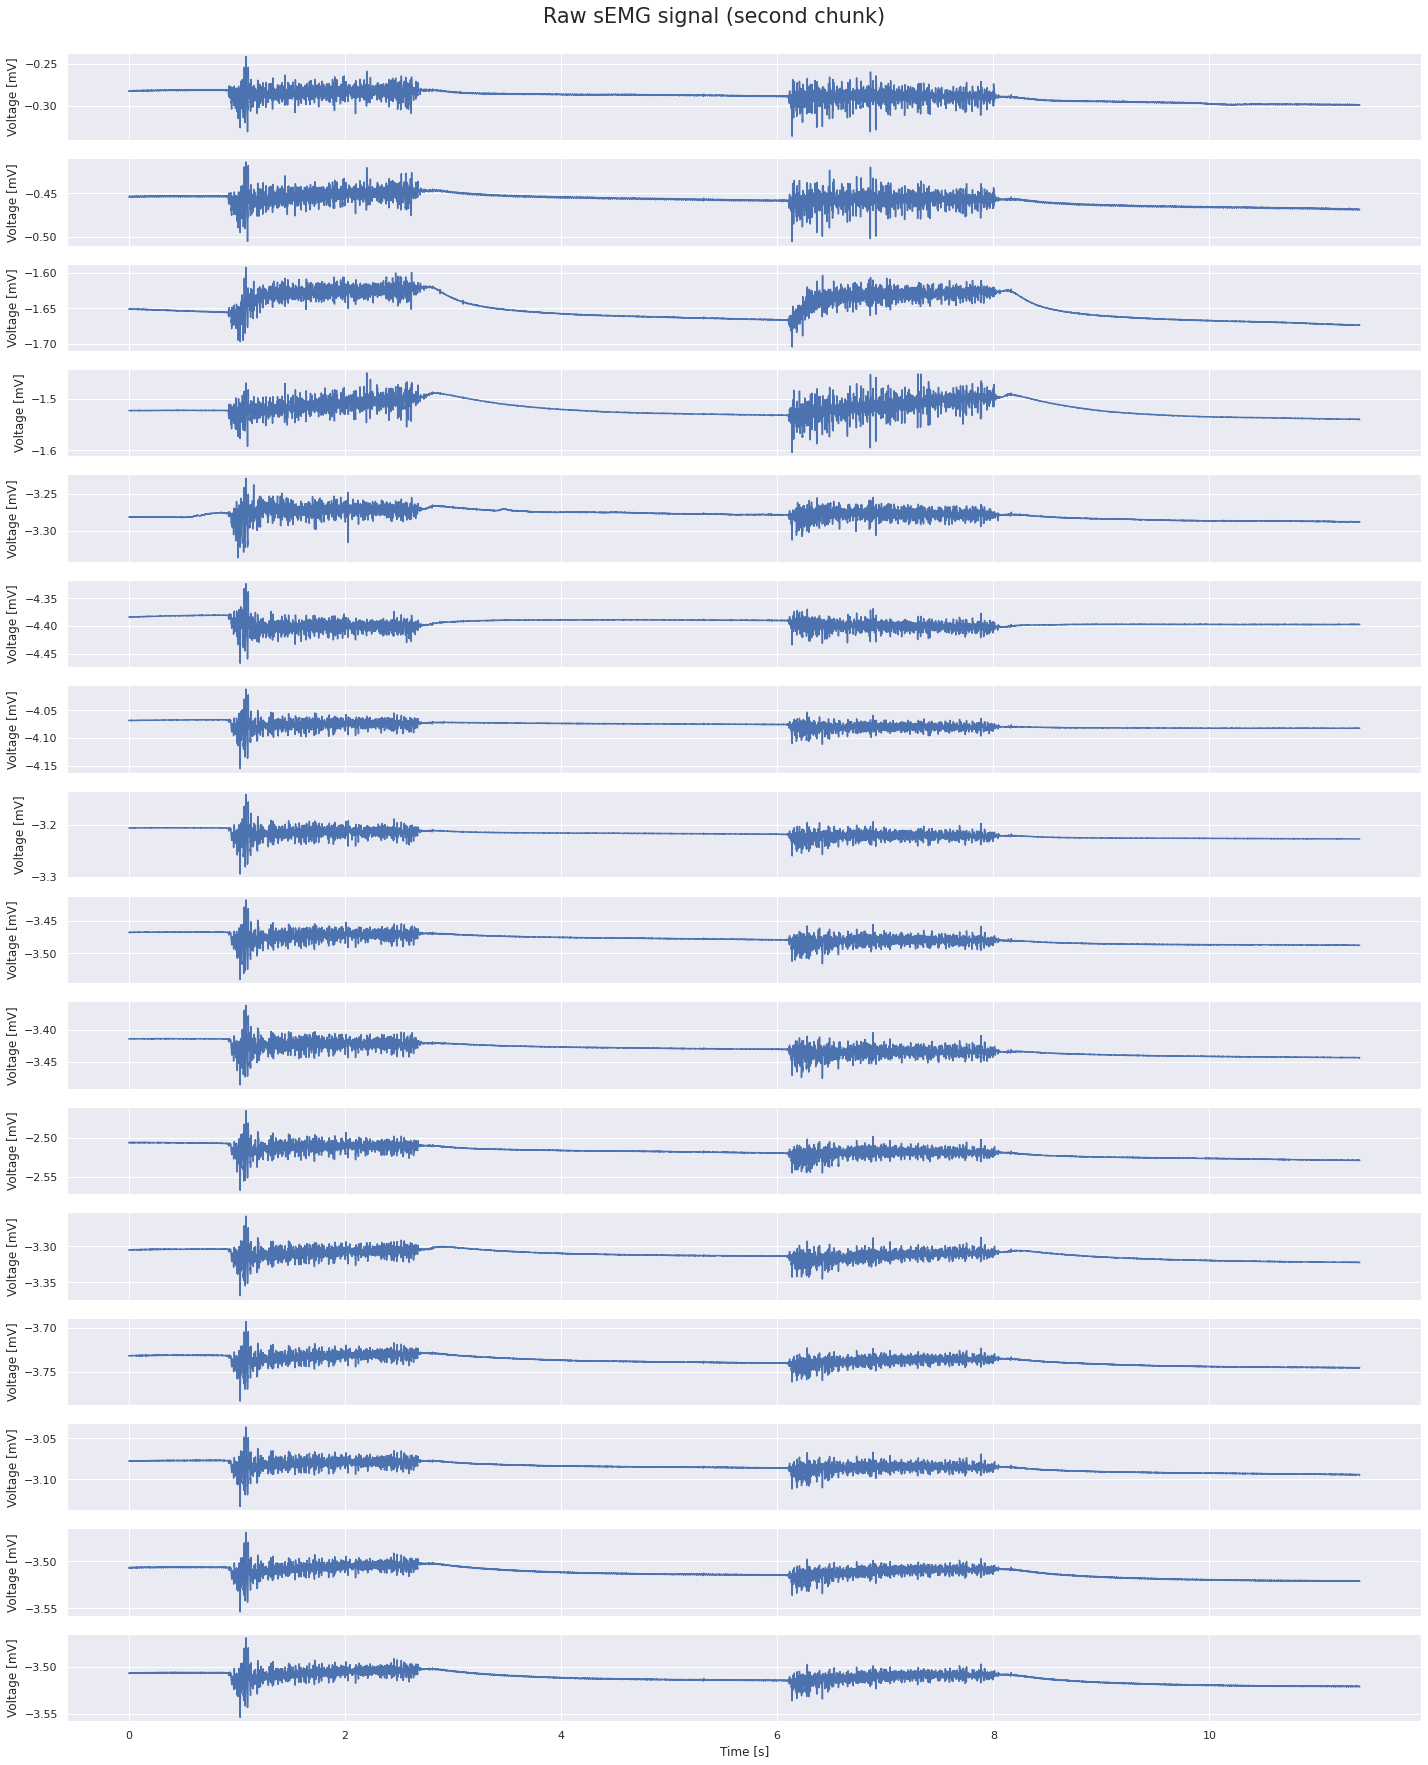

In [3]:
emg2 = semg_bss.datasets.biowolf.load_biowolf(DATA_DIR, n_sig=2)

semg_bss.plt.plot_signal(
    emg2,
    fs=FS_EMG,
    title="Raw sEMG signal (second chunk)",
    fig_size=(20, 25)
)

As it can be seen, the signals present a downward trend and are very noisy: let's correct this by applying a band-pass filter with 10-1000 Hz cutoff frequencies. Let's also remove the powerline noise with a notch filter at 50 Hz.

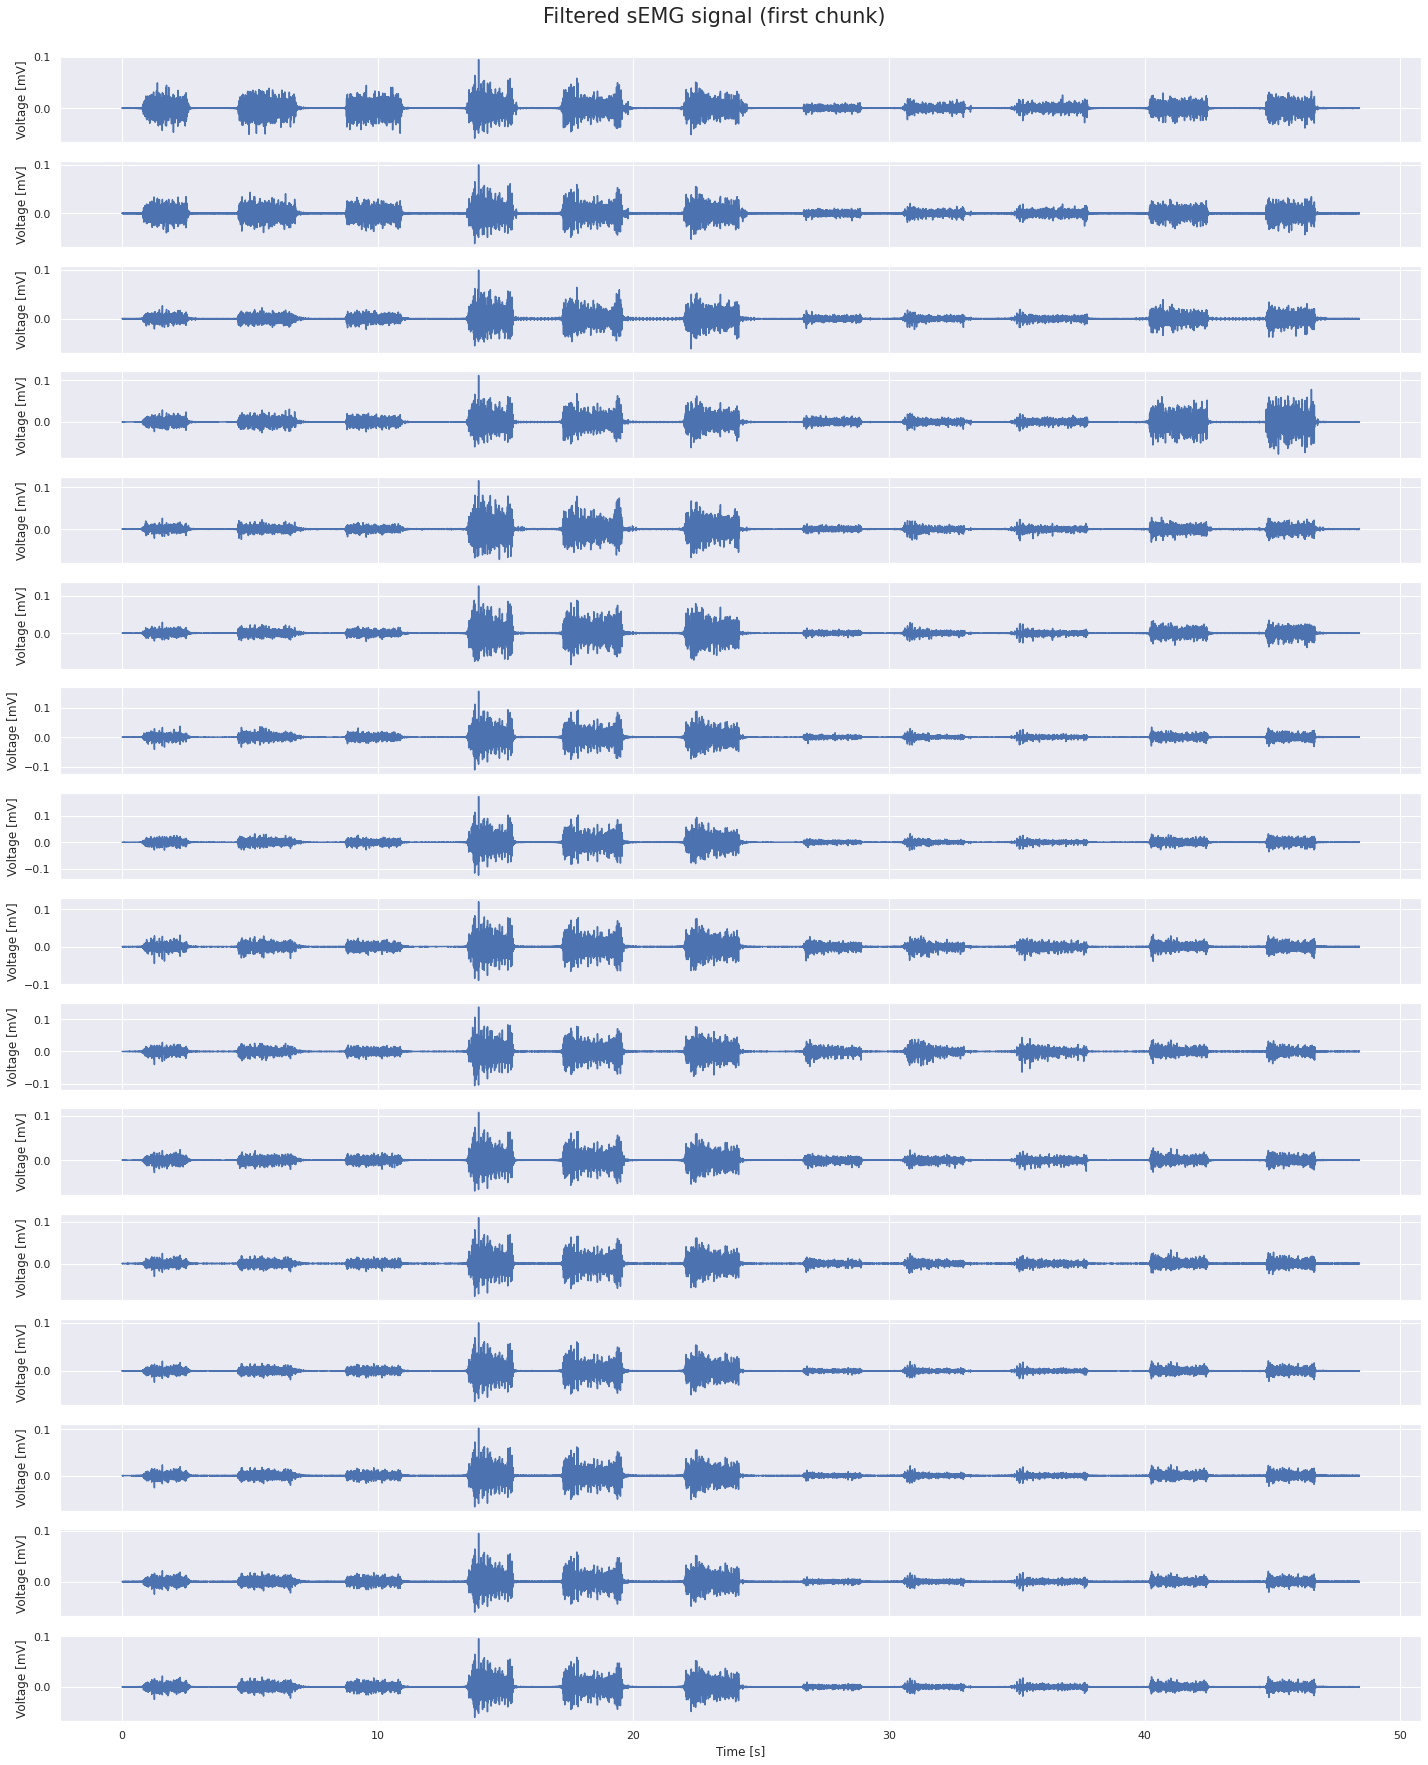

In [4]:
# Filter signal
emg1 = semg_bss.preprocessing.filter_signal(
    emg1,
    fs=FS_EMG,
    min_freq=10,
    max_freq=1000,
    notch_freqs=[50]
)

semg_bss.plt.plot_signal(
    emg1,
    fs=FS_EMG,
    title="Filtered sEMG signal (first chunk)",
    fig_size=(20, 25)
)

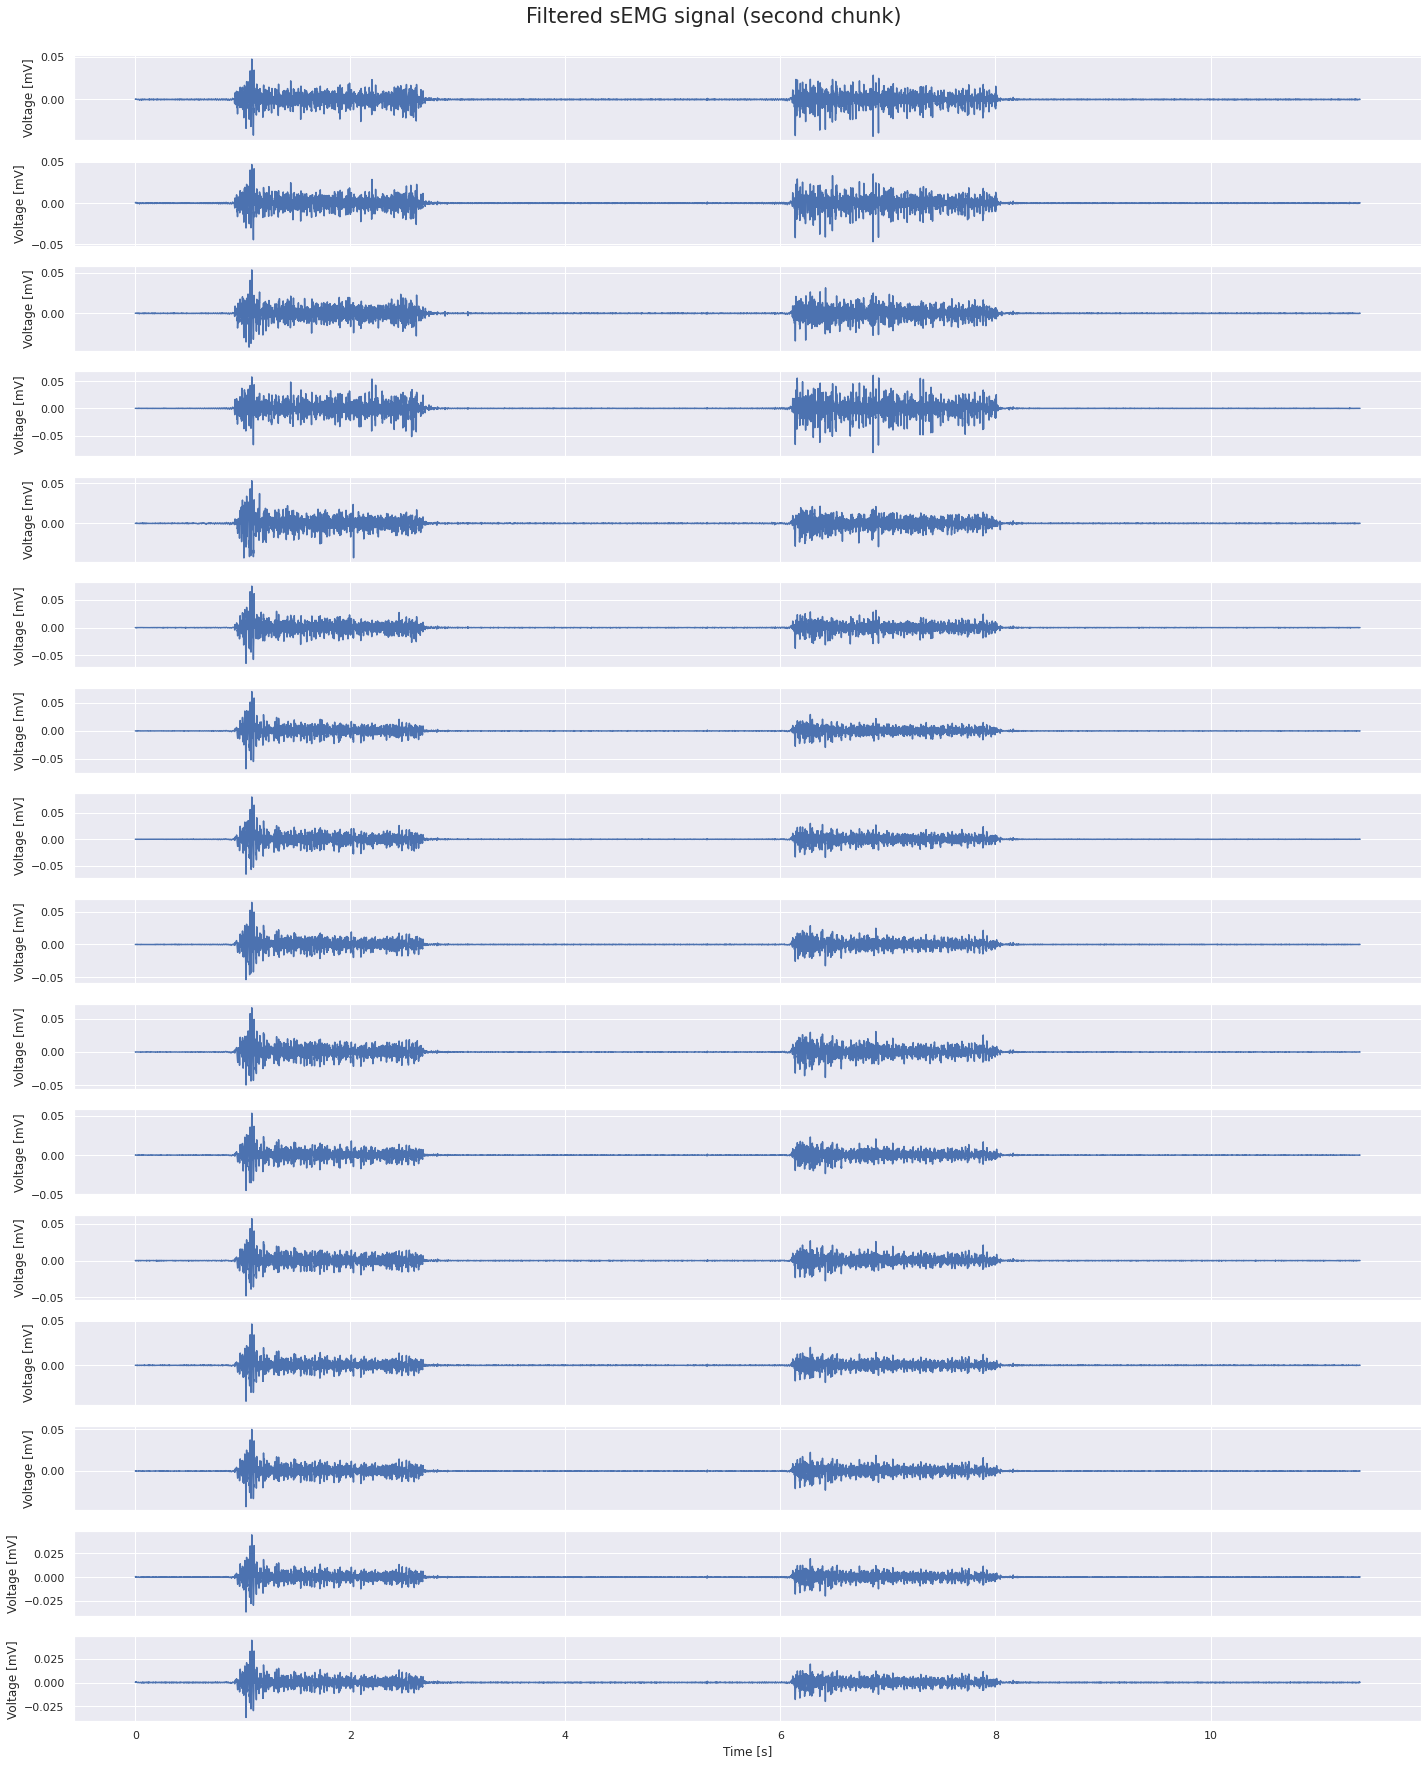

In [5]:
# Filter signal
emg2 = semg_bss.preprocessing.filter_signal(
    emg2,
    fs=FS_EMG,
    min_freq=10,
    max_freq=1000,
    notch_freqs=[50]
)

semg_bss.plt.plot_signal(
    emg2,
    fs=FS_EMG,
    title="Filtered sEMG signal (second chunk)",
    fig_size=(20, 25)
)

Since the two chunks were recorded one after the other during the same session, we can concatenate them and treat them as a single signal.

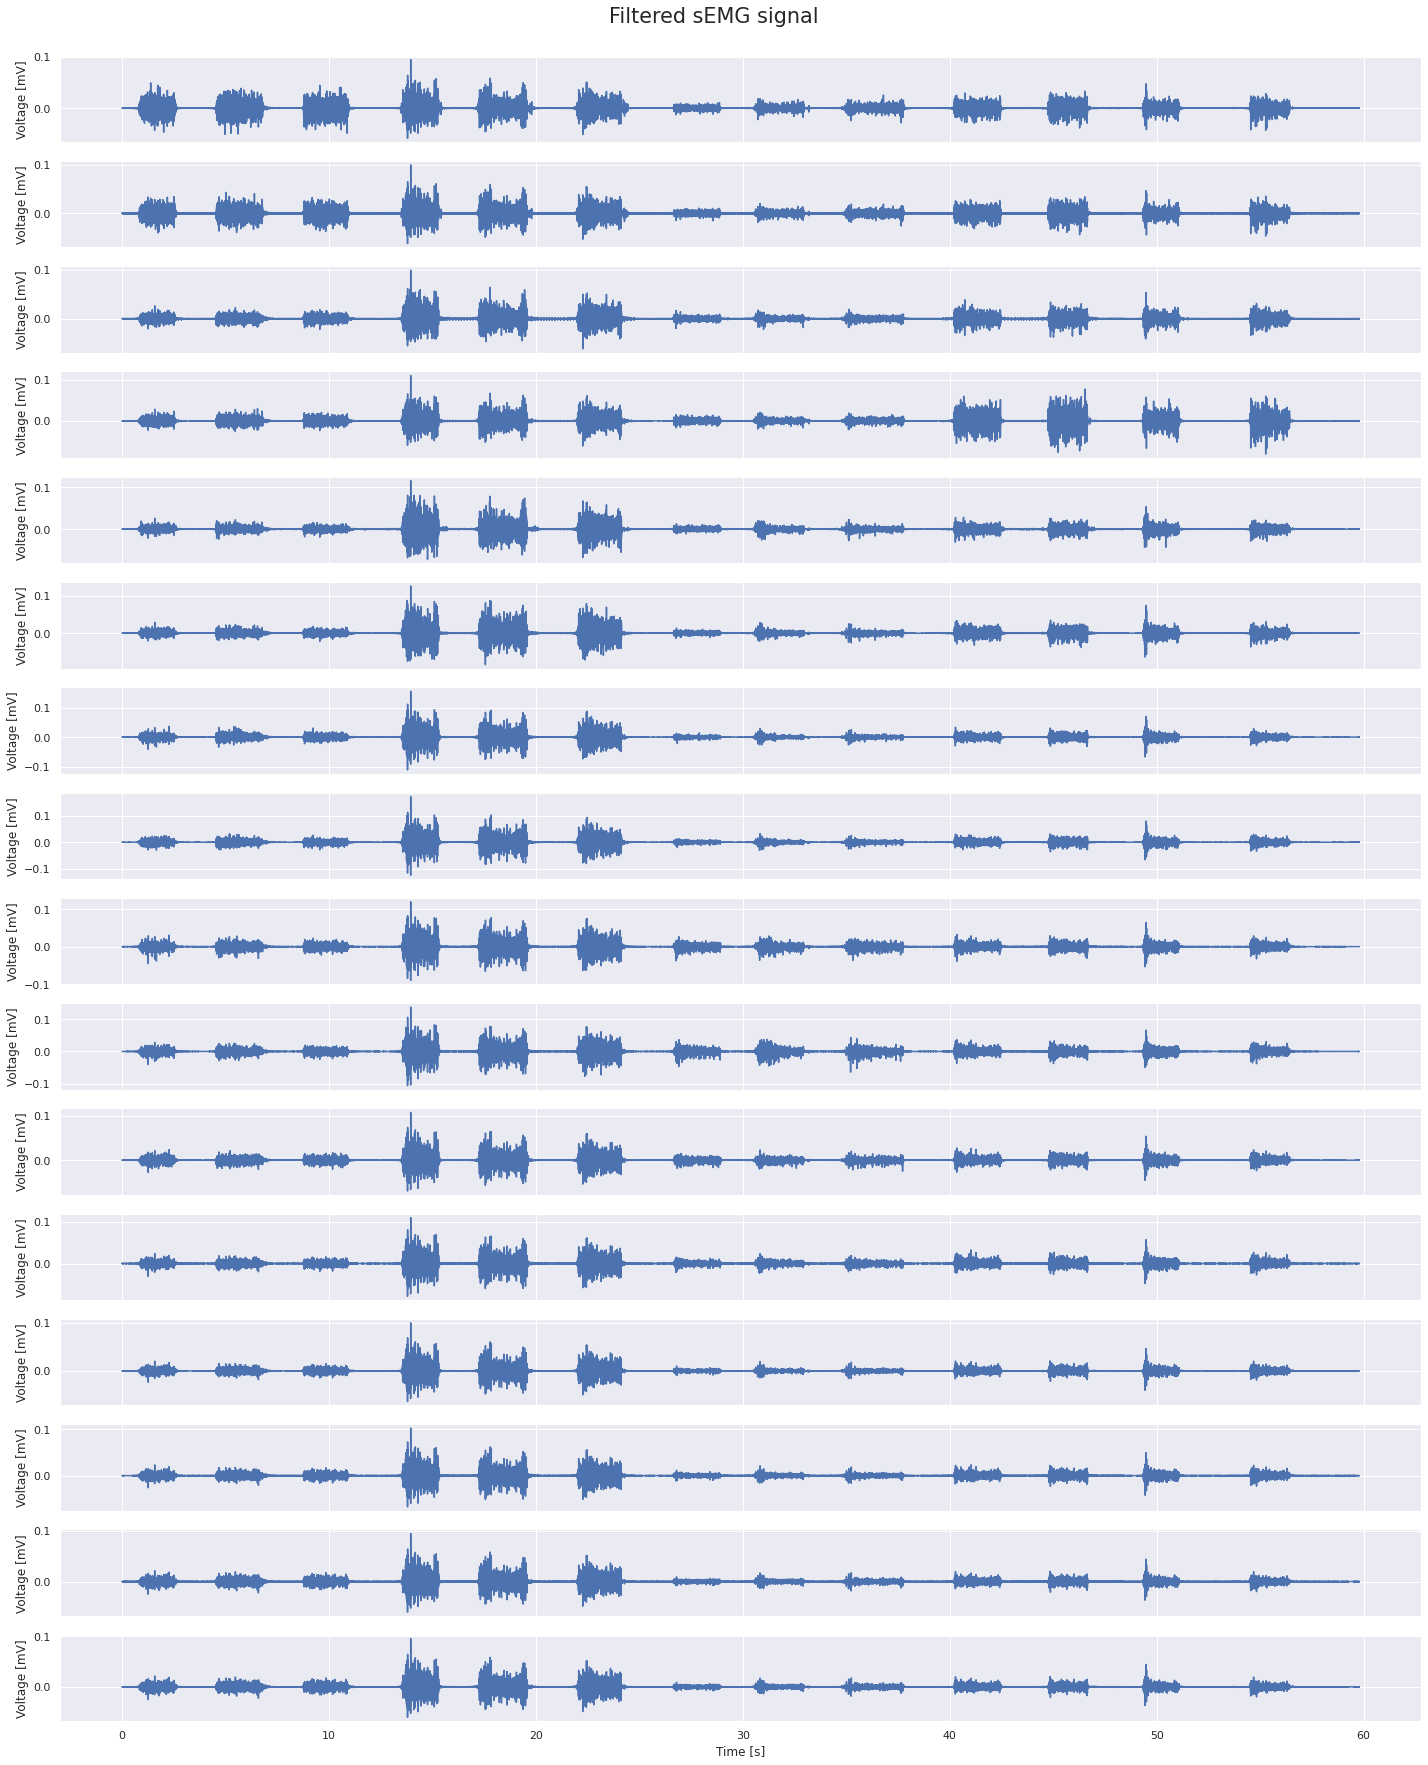

In [6]:
emg = np.hstack([emg1, emg2])
n_channels, n_samples = emg.shape

semg_bss.plt.plot_signal(
    emg,
    fs=FS_EMG,
    title="Filtered sEMG signal",
    fig_size=(20, 25)
)

Now we can better visualize the 13 muscle contractions, which we must label accordingly:
- the contractions no. 1-3 correspond to "hand_open";
- the contractions no. 4-6 correspond to "fist";
- the contractions no. 7-9 correspond to "index";
- the contractions no. 10-13 correspond to "ok".

We can automate this by applying a root mean square (RMS) filter, and then by running k-means with 2 classes (rest/contraction) to find the contraction threshold.

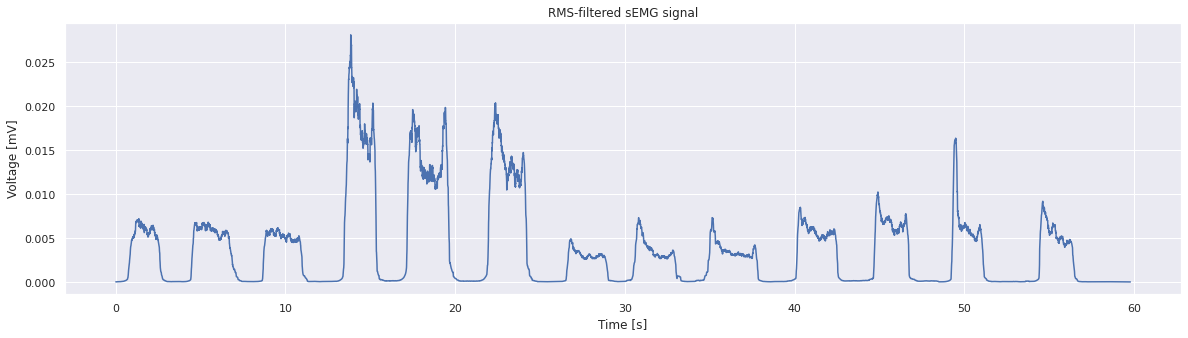

In [7]:
def apply_rms(sig, win_len):
    flt = np.ones(win_len) / win_len
    return np.apply_along_axis(lambda ch: np.sqrt(np.convolve(ch, flt, "same")), axis=1, arr=np.square(sig))

emg_rms = apply_rms(
    emg,
    win_len=int(0.2 * FS_EMG)  # 200 ms
)
emg_rms = np.mean(emg_rms, axis=0)  # take the mean across channels
x = np.arange(n_samples) / FS_EMG

plt.figure(figsize=(20, 5))
plt.title("RMS-filtered sEMG signal")
plt.plot(x, emg_rms)
plt.xlabel("Time [s]")
plt.ylabel("Voltage [mV]")
plt.show()

Let's run k-means on the contractions with the smallest magnitude, namely the 7th, 8th and 9th (those associated to the "index" gesture), which spans from ~26 s to ~39 s.

Duration of contraction n. 1: 1.83 s
Duration of contraction n. 2: 2.42 s
Duration of contraction n. 3: 2.29 s
Duration of contraction n. 4: 1.96 s
Duration of contraction n. 5: 2.59 s
Duration of contraction n. 6: 2.35 s
Duration of contraction n. 7: 2.31 s
Duration of contraction n. 8: 2.47 s
Duration of contraction n. 9: 2.92 s
Duration of contraction n. 10: 2.42 s
Duration of contraction n. 11: 2.06 s
Duration of contraction n. 12: 1.88 s
Duration of contraction n. 13: 2.02 s


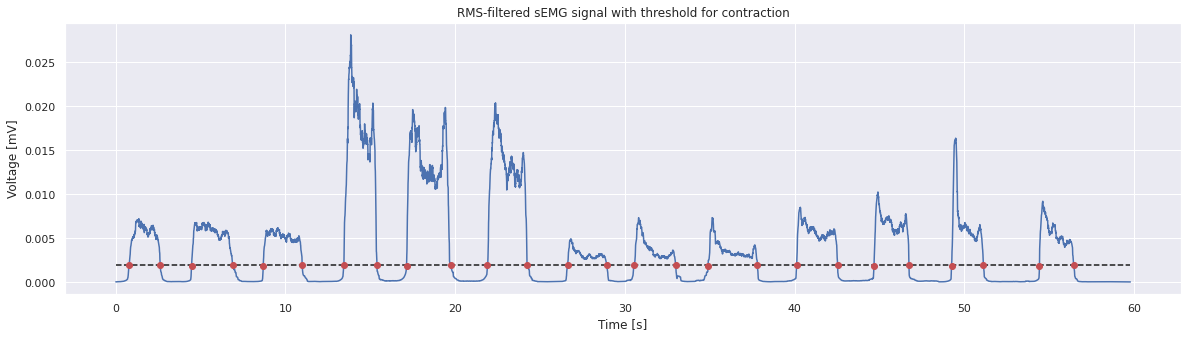

In [8]:
# Perform k-means with 2 clusters (rest and contraction)
idx_from = 26 * FS_EMG  # 26 s
idx_to = 39 * FS_EMG  # 39 s
centroids, _ = kmeans2(
    emg_rms[idx_from:idx_to].reshape(-1, 1), k=2, minit="++", seed=SEED
)
# Compute threshold
threshold = centroids.mean()

# Find t values at which the RMS-filtered signal crosses the threshold
idx = np.argwhere(np.diff(np.sign(threshold - emg_rms))).flatten()

# Check contraction duration
k = 1
for i in range(0, idx.size, 2):
    print(f"Duration of contraction n. {k}: {(idx[i + 1] - idx[i]) / FS_EMG:.2f} s")
    k += 1

# Plot RMS-filtered signal with threshold
plt.figure(figsize=(20, 5))
plt.title("RMS-filtered sEMG signal with threshold for contraction")
plt.plot(x, emg_rms)
plt.xlabel("Time [s]")
plt.ylabel("Voltage [mV]")
plt.hlines(y=threshold, xmin=0, xmax=n_samples / FS_EMG, colors="k", linestyles="dashed")
plt.plot(x[idx], emg_rms[idx], "ro")
plt.show()

Now let's label the signal accordingly: the 200 ms before and after the threshold crossing will be considered "transition".

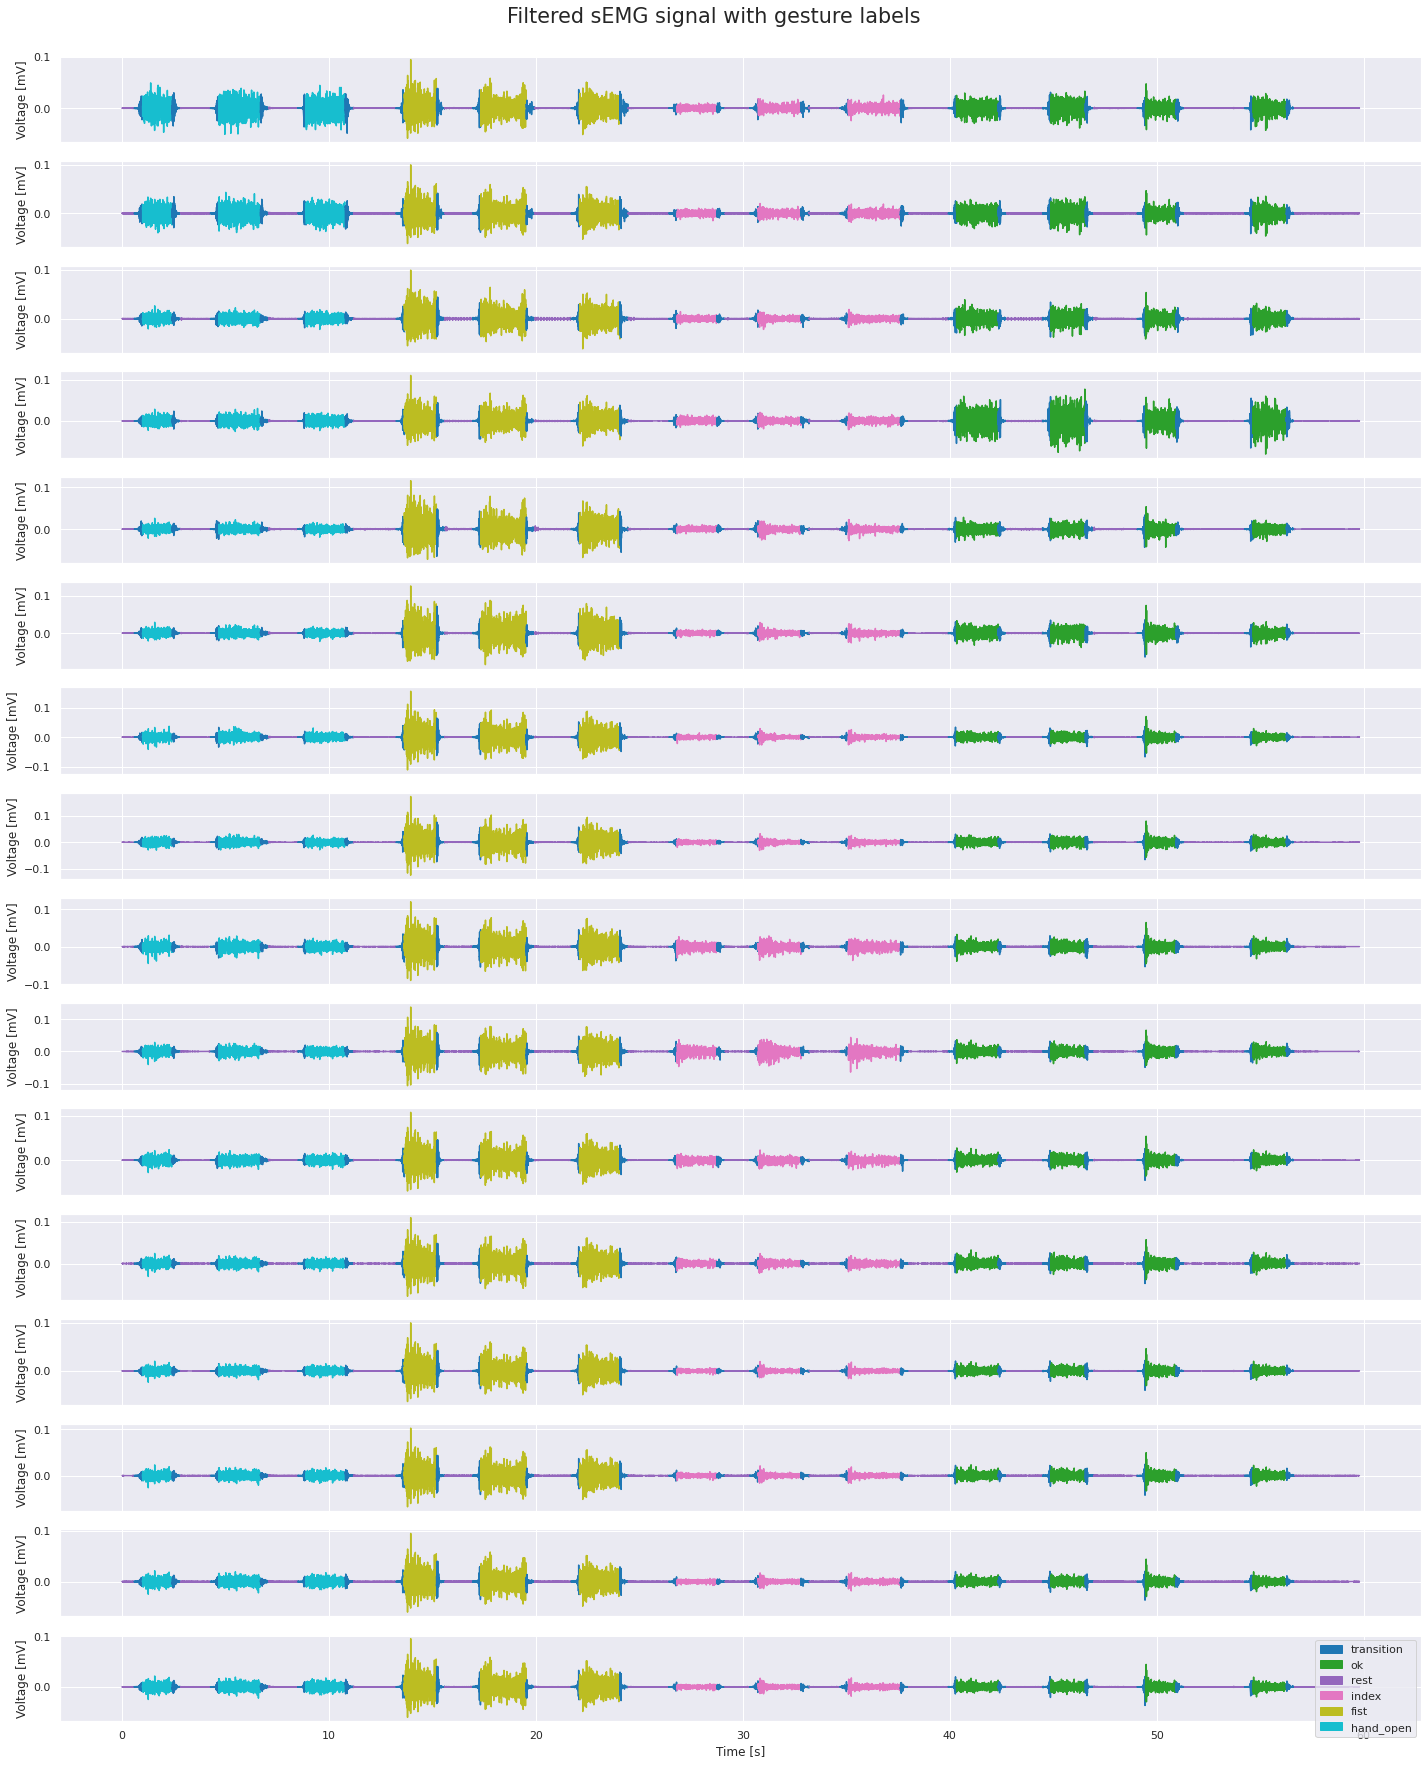

In [9]:
tr_pad = int(0.2 * FS_EMG)  # 200 ms
labels = [
    ("rest", 0, idx[0] - tr_pad),
    ("transition", idx[0] - tr_pad, idx[0] + tr_pad),
    ("hand_open", idx[0] + tr_pad, idx[1] - tr_pad),
    ("transition", idx[1] - tr_pad, idx[1] + tr_pad),
    ("rest", idx[1] + tr_pad, idx[2] - tr_pad),
    ("transition", idx[2] - tr_pad, idx[2] + tr_pad),
    ("hand_open", idx[2] + tr_pad, idx[3] - tr_pad),
    ("transition", idx[3] - tr_pad, idx[3] + tr_pad),
    ("rest", idx[3] + tr_pad, idx[4] - tr_pad),
    ("transition", idx[4] - tr_pad, idx[4] + tr_pad),
    ("hand_open", idx[4] + tr_pad, idx[5] - tr_pad),
    ("transition", idx[5] - tr_pad, idx[5] + tr_pad),
    ("rest", idx[5] + tr_pad, idx[6] - tr_pad),
    ("transition", idx[6] - tr_pad, idx[6] + tr_pad),
    ("fist", idx[6] + tr_pad, idx[7] - tr_pad),
    ("transition", idx[7] - tr_pad, idx[7] + tr_pad),
    ("rest", idx[7] + tr_pad, idx[8] - tr_pad),
    ("transition", idx[8] - tr_pad, idx[8] + tr_pad),
    ("fist", idx[8] + tr_pad, idx[9] - tr_pad),
    ("transition", idx[9] - tr_pad, idx[9] + tr_pad),
    ("rest", idx[9] + tr_pad, idx[10] - tr_pad),
    ("transition", idx[10] - tr_pad, idx[10] + tr_pad),
    ("fist", idx[10] + tr_pad, idx[11] - tr_pad),
    ("transition", idx[11] - tr_pad, idx[11] + tr_pad),
    ("rest", idx[11] + tr_pad, idx[12] - tr_pad),
    ("transition", idx[12] - tr_pad, idx[12] + tr_pad),
    ("index", idx[12] + tr_pad, idx[13] - tr_pad),
    ("transition", idx[13] - tr_pad, idx[13] + tr_pad),
    ("rest", idx[13] + tr_pad, idx[14] - tr_pad),
    ("transition", idx[14] - tr_pad, idx[14] + tr_pad),
    ("index", idx[14] + tr_pad, idx[15] - tr_pad),
    ("transition", idx[15] - tr_pad, idx[15] + tr_pad),
    ("rest", idx[15] + tr_pad, idx[16] - tr_pad),
    ("transition", idx[16] - tr_pad, idx[16] + tr_pad),
    ("index", idx[16] + tr_pad, idx[17] - tr_pad),
    ("transition", idx[17] - tr_pad, idx[17] + tr_pad),
    ("rest", idx[17] + tr_pad, idx[18] - tr_pad),
    ("transition", idx[18] - tr_pad, idx[18] + tr_pad),
    ("ok", idx[18] + tr_pad, idx[19] - tr_pad),
    ("transition", idx[19] - tr_pad, idx[19] + tr_pad),
    ("rest", idx[19] + tr_pad, idx[20] - tr_pad),
    ("transition", idx[20] - tr_pad, idx[20] + tr_pad),
    ("ok", idx[20] + tr_pad, idx[21] - tr_pad),
    ("transition", idx[21] - tr_pad, idx[21] + tr_pad),
    ("rest", idx[21] + tr_pad, idx[22] - tr_pad),
    ("transition", idx[22] - tr_pad, idx[22] + tr_pad),
    ("ok", idx[22] + tr_pad, idx[23] - tr_pad),
    ("transition", idx[23] - tr_pad, idx[23] + tr_pad),
    ("rest", idx[23] + tr_pad, idx[24] - tr_pad),
    ("transition", idx[24] - tr_pad, idx[24] + tr_pad),
    ("ok", idx[24] + tr_pad, idx[25] - tr_pad),
    ("transition", idx[25] - tr_pad, idx[25] + tr_pad),
    ("rest", idx[25] + tr_pad, n_samples)
]

semg_bss.plt.plot_signal(
    emg,
    fs=FS_EMG,
    title="Filtered sEMG signal with gesture labels",
    labels=labels,
    fig_size=(20, 25)
)

Let's save the labels to CSV file.

In [10]:
with open(os.path.join(DATA_DIR, "labels.csv"), mode="w") as f:
    writer = csv.writer(f)
    # Write header
    writer.writerow(["Gesture", "From", "To"])
    # Write labels
    writer.writerows(labels)

## 2. Decomposition
First of all, we need a calibration signal that includes all the gestures of interest. For this purpose, we will slice out the 3rd, 4th, 9th and 10th contractions (i.e., the 7.5--16 s segment and the 34--44 s segment), and concatenate them in order to obtain our calibration signal.

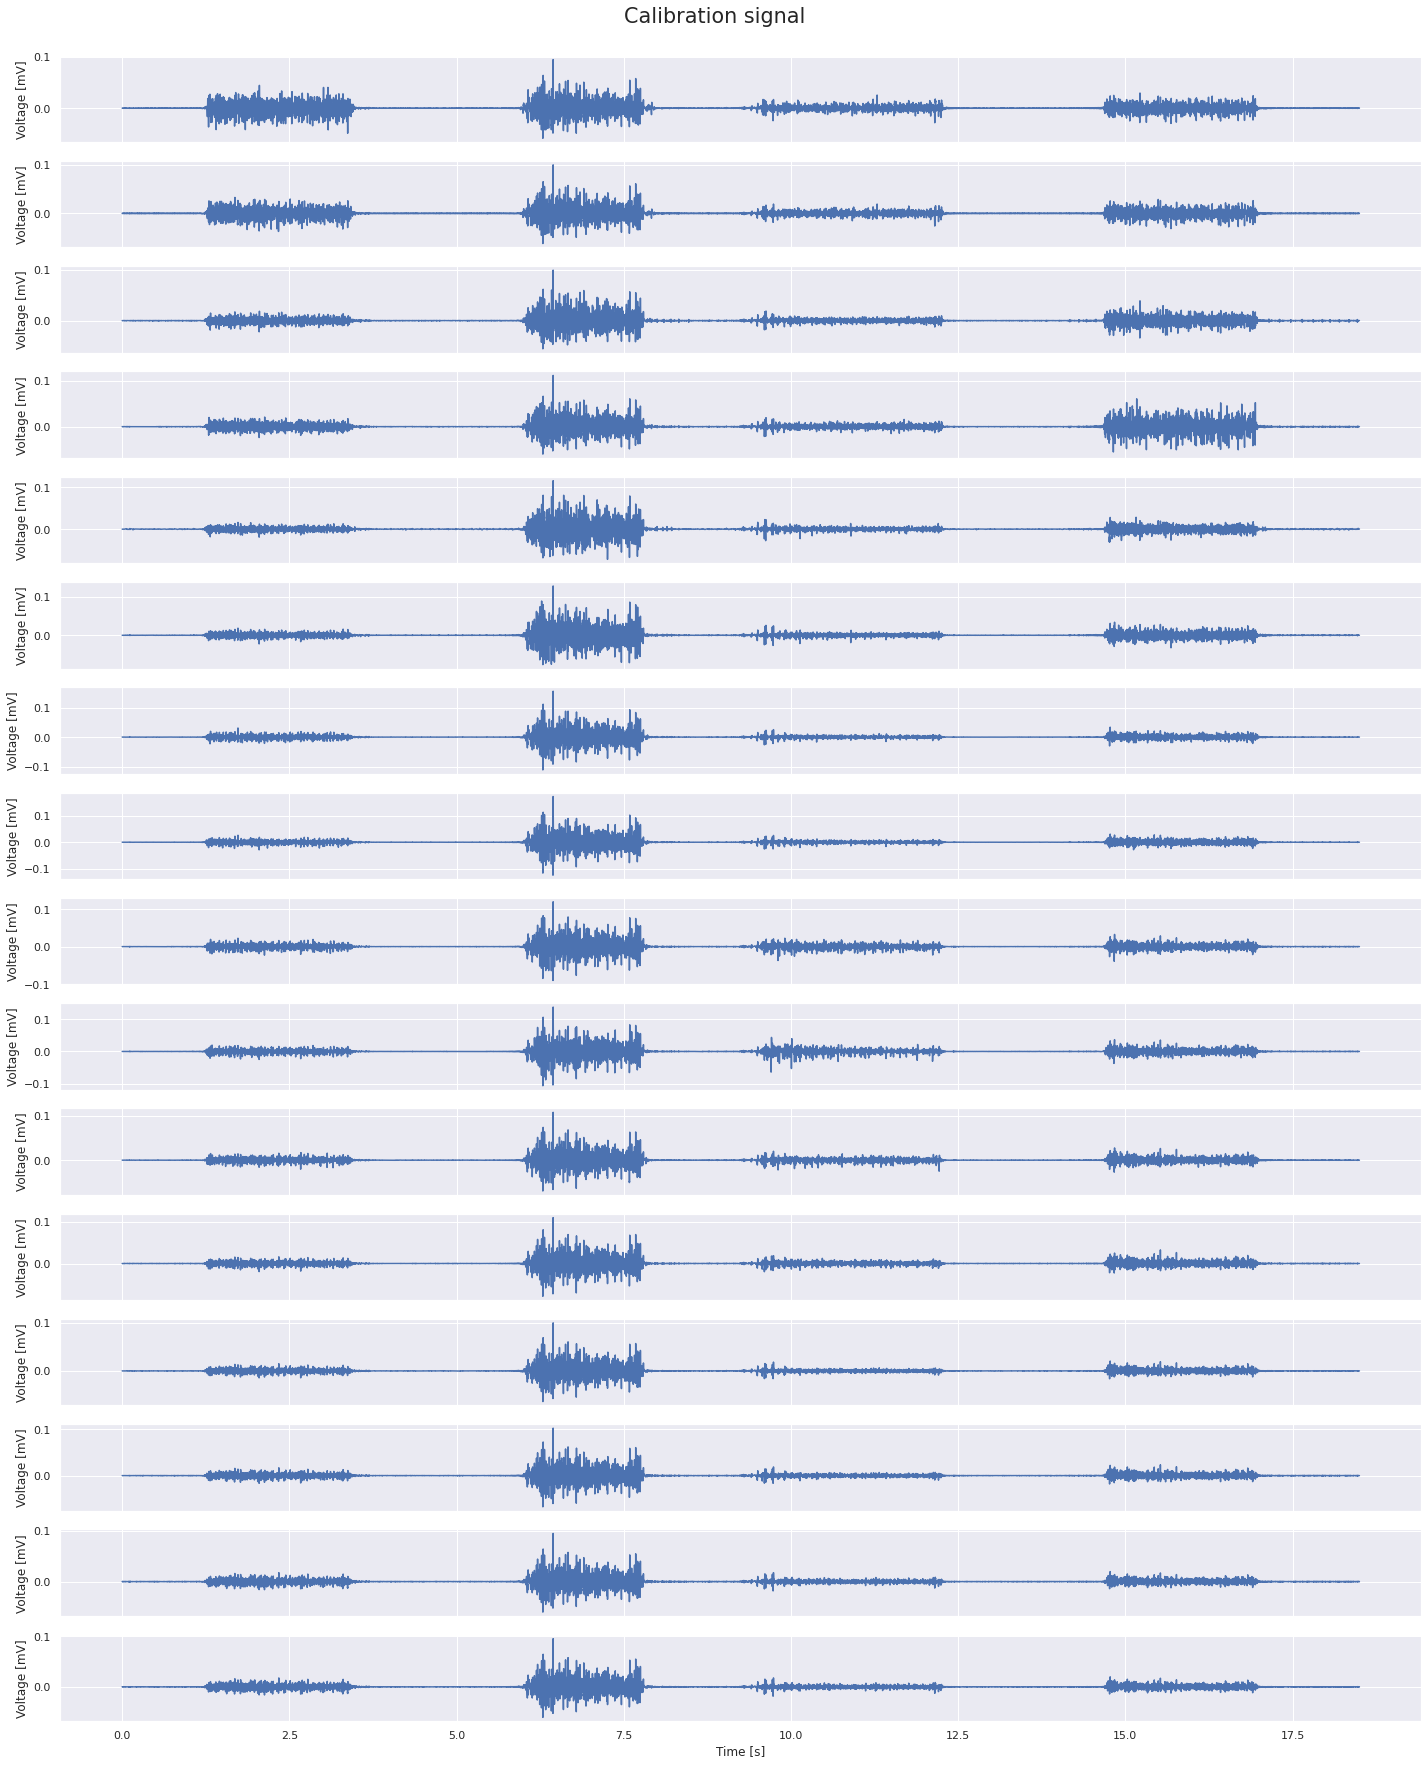

In [11]:
idx_from = int(7.5 * FS_EMG)
idx_to = int(16 * FS_EMG)
tmp1 = emg1[:, idx_from:idx_to]
idx_from = int(34 * FS_EMG)
idx_to = int(44 * FS_EMG)
tmp2 = emg1[:, idx_from:idx_to]

emg_calib = np.hstack([tmp1, tmp2])
_, calib_len = emg_calib.shape

semg_bss.plt.plot_signal(
    emg_calib,
    fs=FS_EMG,
    title="Calibration signal",
    fig_size=(20, 25)
)

Let's now create an instance of `EMGSeparator` with an extension factor `f_e=4`.

In [12]:
f_e = 4
model_path = f"decomp_models/bio/{'recal' if ORDERING is None else ORDERING}/{MAX_COMP}/emg_separator.pkl"

if not LOAD_SAVED_MODELS:
    emg_separator = semg_bss.EMGSeparator(
        max_sources=MAX_COMP,
        samp_freq=FS_EMG,
        f_e=f_e,
        sorting_strategy=ORDERING,
        seed=SEED
    )
else:
    emg_separator = semg_bss.EMGSeparator.load_from_file(model_path)

Let's calibrate the `EMGSeparator` instance: the shortest contraction lasts 1.96 +/- 0.2 s while the longest lasts 2.92 +/- 0.2 s, out of 18.5 s. Therefore, if we consider a minimum of 5 pulses-per-second (pps) and a maximum of 250 pps, the valid range for a MU would be:

- `min_spike_pps = 5 pps * 1.76 s / (18.5 s) = 0.476 pps`
- `max_spike_pps = 250 pps * 3.12 s / (18.5 s) = 42.0 pps`

Extracted 19 MUs.


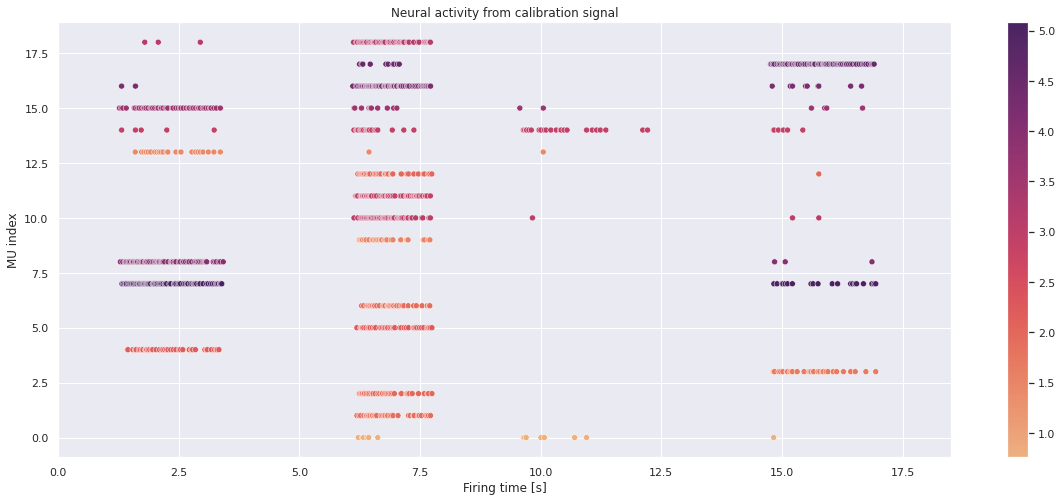

In [13]:
if not LOAD_SAVED_MODELS:
    # Calibrate instance on the given signal
    firings_calib = emg_separator.calibrate(
        emg_calib,
        min_spike_pps=0.476,
        max_spike_pps=42.0
    )
    # Save instance to file
    emg_separator.save_to_file(model_path)
else:
    firings_calib = emg_separator.decompose(
        emg_calib,
        min_spike_pps=0.476,
        max_spike_pps=42.0
    )
print(f"Extracted {emg_separator.n_mu} MUs.")

# Visualize firings
semg_bss.plt.raster_plot(
    firings_calib,
    title="Neural activity from calibration signal",
    sig_span=(0, calib_len / FS_EMG),
    fig_size=(20, 8)
)

Let's visualize the source MUAPTs.

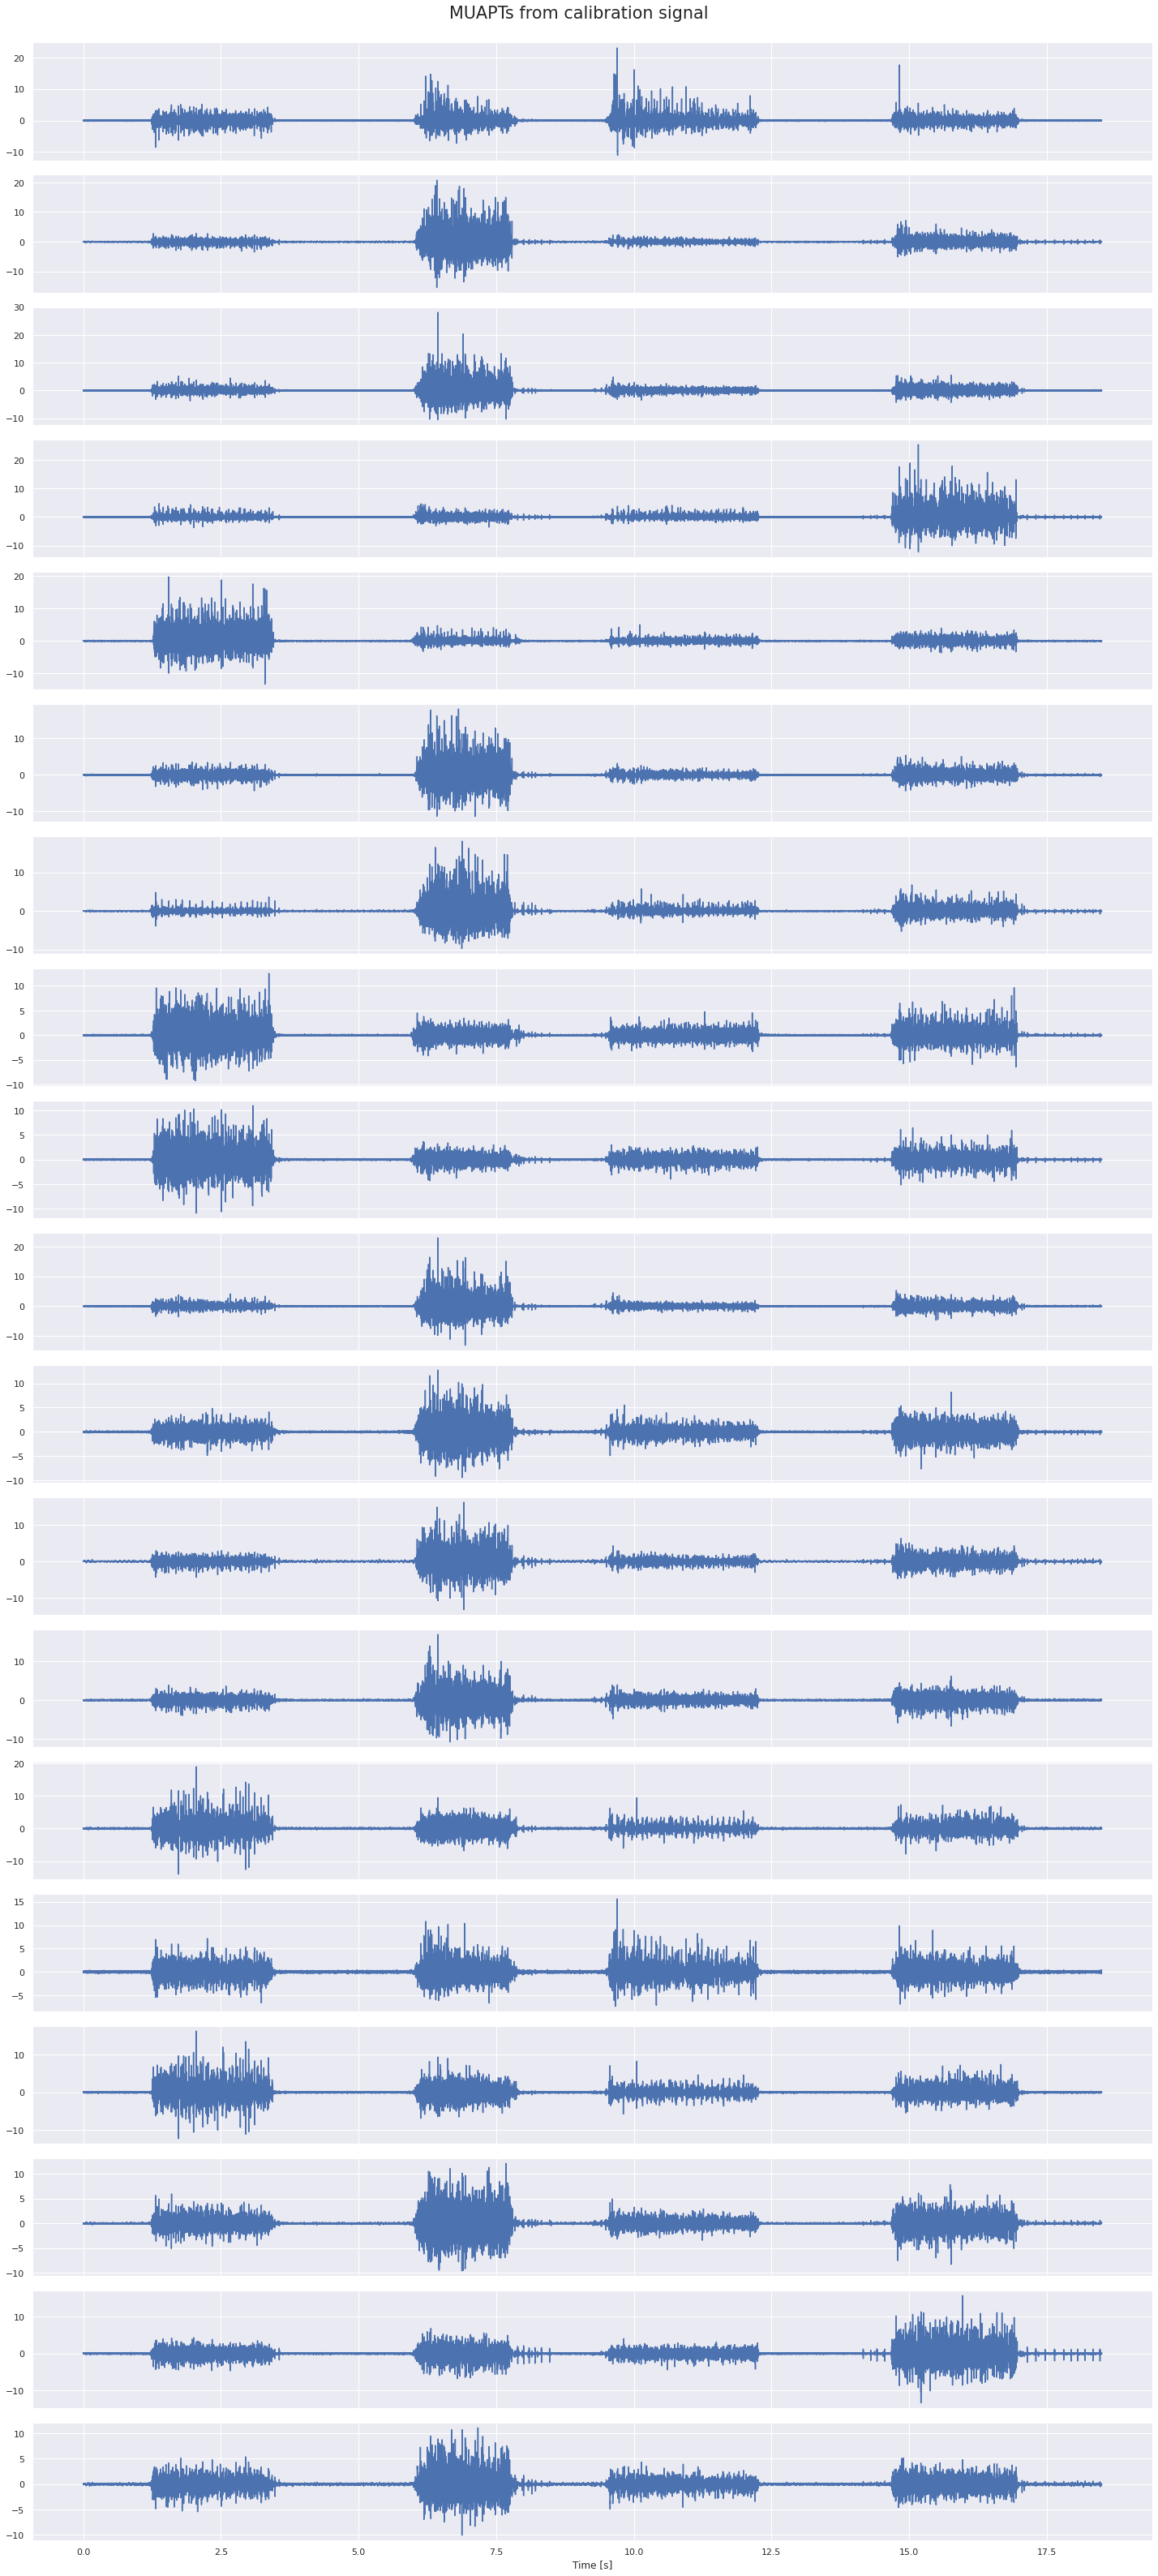

In [14]:
muapts = emg_separator.project(emg_calib)

_, ax = plt.subplots(emg_separator.n_mu, 1, figsize=(20, 45), sharex="all")
for i in range(emg_separator.n_mu):
    ax[i].plot(np.arange(muapts.shape[1]) / FS_EMG, muapts[i])
plt.xlabel("Time [s]")
plt.suptitle("MUAPTs from calibration signal", fontsize="xx-large")
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Let's now test the decomposition model on 4 unseen segments of the signal, one per gesture.

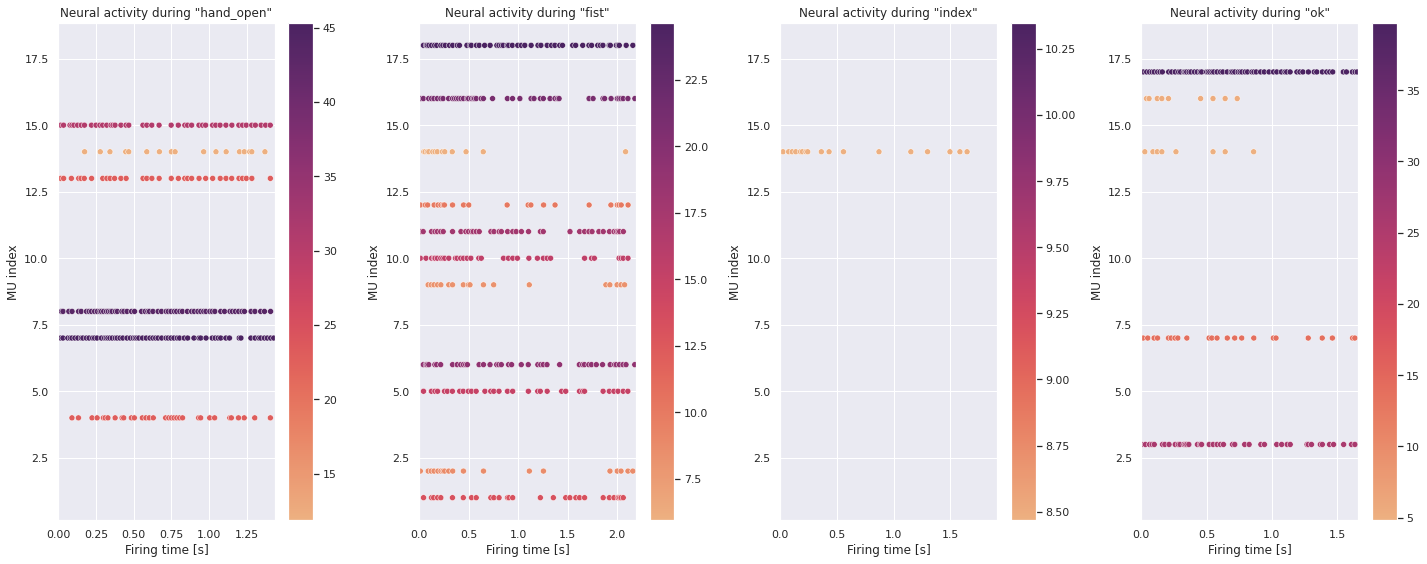

In [15]:
g1_segments = [(g_from, g_to) for g, g_from, g_to in labels if g == "hand_open"]
g2_segments = [(g_from, g_to) for g, g_from, g_to in labels if g == "fist"]
g3_segments = [(g_from, g_to) for g, g_from, g_to in labels if g == "index"]
g4_segments = [(g_from, g_to) for g, g_from, g_to in labels if g == "ok"]

# Extract firings
g1_from, g1_to = g1_segments[0]  # 1st "hand_open" gesture
g1_firings = emg_separator.decompose(emg[:, g1_from:g1_to])
g2_from, g2_to = g2_segments[1]  # 2nd "fist" gesture
g2_firings = emg_separator.decompose(emg[:, g2_from:g2_to])
g3_from, g3_to = g3_segments[0]  # 1st "index" gesture
g3_firings = emg_separator.decompose(emg[:, g3_from:g3_to])
g4_from, g4_to = g4_segments[1]  # 2nd "ok" gesture
g4_firings = emg_separator.decompose(emg[:, g4_from:g4_to])

semg_bss.plt.raster_plot(
    firings=[g1_firings, g2_firings, g3_firings, g4_firings],
    title=[
        "Neural activity during \"hand_open\"",
        "Neural activity during \"fist\"",
        "Neural activity during \"index\"",
        "Neural activity during \"ok\""
    ],
    sig_span=[
        (0, (g1_to - g1_from) / FS_EMG),
        (0, (g2_to - g2_from) / FS_EMG),
        (0, (g3_to - g3_from) / FS_EMG),
        (0, (g4_to - g4_from) / FS_EMG)
    ],
    n_cols=4,
    fig_size=(20, 8)
)

As we can see the order of active MUs remains consistent with the calibration signal.

## 3a. Classification with MLP-500 (intra-session)
Let's prepare the training data for the classification task: we'll use 500 ms-long slices from each contraction. To avoid data leakage, the test set will include the 2nd repetition of each gesture, since they weren't used for calibration.

In [16]:
slice_len = 0.5  # = 500 ms
step_len = 0.05  # = 50 ms

# Matrix associated with rest
rest_mtx = np.zeros(
    shape=(1, emg_separator.n_mu * int(slice_len * FS_EMG)),
    dtype=np.int8
)

# Gesture dict
gestures = ["rest", "hand_open", "fist", "index", "ok"]
gesture_dict = {g: i for i, g in enumerate(gestures)}
inv_gesture_dict = {i: g for i, g in enumerate(gestures)}

# Output matrices
X_trainval = np.zeros(shape=(0, emg_separator.n_mu * int(slice_len * FS_EMG)))
y_trainval = np.zeros(shape=(0,), dtype=np.int8)
X_test = np.zeros(shape=(0, emg_separator.n_mu * int(slice_len * FS_EMG)))
y_test = np.zeros(shape=(0,), dtype=np.int8)

# Iterate over gestures
for gesture in gestures:
    g_labels = [(idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture]
    # Iterate over gesture repetitions
    for i, (g_from, g_to) in enumerate(g_labels):
        # Extract gesture and decompose it
        g_slice = emg[:, g_from:g_to]
        firings = emg_separator.decompose(g_slice)
        
        # Iterate over slices
        start = 0
        stop = (g_to - g_from) / FS_EMG
        while start < stop - slice_len:
            if gesture != "rest":  # contraction
                if firings.empty:  # unexpected empty firings during contraction
                    print(f"MU extraction failed on segment {i + 1} of gesture {gesture}.")
                    break
                else:  # expected non-empty firings during contraction
                    # Slice firings
                    cur_firings = firings[(firings["Firing time"] >= start) & (firings["Firing time"] < start + slice_len)]
                    if i != 1:  # train/val
                        X_trainval = np.concatenate([
                            X_trainval,
                            semg_bss.clf.df_to_dense(
                                cur_firings,
                                emg_separator.n_mu,
                                offset=start,
                                sig_len=slice_len,
                                fs=FS_EMG
                            ).flatten().reshape(1, -1)
                        ])
                        y_trainval = np.concatenate([y_trainval, (gesture_dict[gesture],)])
                    else:  # test
                        X_test = np.concatenate([
                            X_test,
                            semg_bss.clf.df_to_dense(
                                cur_firings,
                                emg_separator.n_mu,
                                offset=start,
                                sig_len=slice_len,
                                fs=FS_EMG
                            ).flatten().reshape(1, -1)
                        ])
                        y_test = np.concatenate([y_test, (gesture_dict[gesture],)])
                    start += step_len
            
            else:  # rest
                if firings.empty:  # expected empty firings during rest state
                    if i not in [1, 4, 7, 10, 13]:
                        X_trainval = np.concatenate([X_trainval, rest_mtx])
                        y_trainval = np.concatenate([y_trainval, (gesture_dict["rest"],)])
                    else:
                        X_test = np.concatenate([X_test, rest_mtx])
                        y_test = np.concatenate([y_test, (gesture_dict["rest"],)])
                    start += step_len
                else:  # unexpected non-empty firings during rest state
                    print(f"MUAPTs detected during rest state.")
                    break

# Split trainval in training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

print("Shape of training data:", X_train.shape, y_train.shape)
print("Shape of validation data:", X_val.shape, y_val.shape)
print("Shape of test data:", X_test.shape, y_test.shape)

Shape of training data: (385, 38000) (385,)
Shape of validation data: (97, 38000) (97,)
Shape of test data: (249, 38000) (249,)


Let's plot the sample distributions.

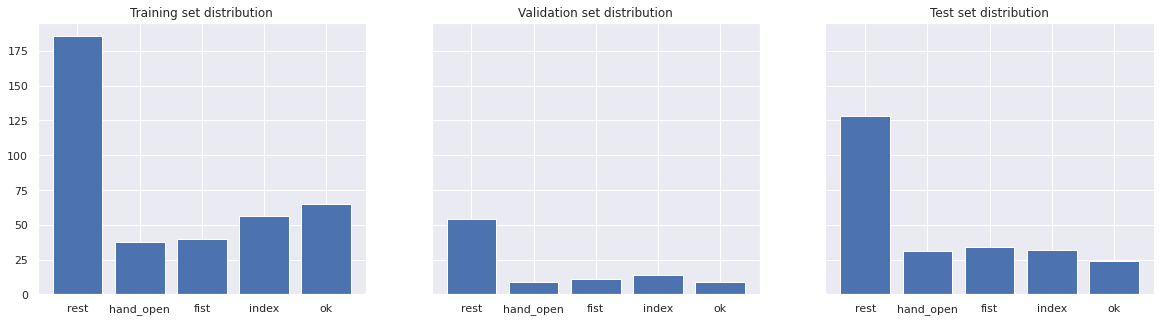

In [17]:
train_count = Counter(y_train)
val_count = Counter(y_val)
test_count = Counter(y_test)

g_range = list(gesture_dict.values())
_, ax = plt.subplots(1, 3, figsize=(20, 5), sharey="all")
ax[0].set_title("Training set distribution")
ax[0].bar(
    x=g_range,
    height=[train_count[g] for g in g_range],
    tick_label=[inv_gesture_dict[g] for g in g_range]
)
ax[1].set_title("Validation set distribution")
ax[1].bar(
    x=g_range,
    height=[val_count[g] for g in g_range],
    tick_label=[inv_gesture_dict[g] for g in g_range]
)
ax[2].set_title("Test set distribution")
ax[2].bar(
    x=g_range,
    height=[test_count[g] for g in g_range],
    tick_label=[inv_gesture_dict[g] for g in g_range]
)
plt.show()

As it can be seen, rest class is far more frequent than the others. Let's correct this by computing a weight score.

In [18]:
train_inv_freq = [X_train.shape[0] / train_count[g] for g in g_range]
test_inv_freq = [X_test.shape[0] / test_count[g] for g in g_range]

train_weights = np.array([train_inv_freq[y] for y in y_train])
test_weights = np.array([test_inv_freq[y] for y in y_test])

Let's create a `DataLoader` for each set, together with a `WeightedRandomSampler`.

In [19]:
# Convert to Torch Dataset
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).long()
train_data = TensorDataset(X_train, y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val).long()
val_data = TensorDataset(X_val, y_val)

# Create sampler
sampler = WeightedRandomSampler(train_weights, num_samples=X_train.shape[0])

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=32, sampler=sampler, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32)

Let's define a simple MLP classifier and train it several times.

Run 1 - Test accuracy: 96.79% - Test accuracy (balanced): 95.00%
Run 2 - Test accuracy: 95.98% - Test accuracy (balanced): 93.75%
Run 3 - Test accuracy: 95.98% - Test accuracy (balanced): 93.75%
Run 4 - Test accuracy: 95.98% - Test accuracy (balanced): 93.75%
Run 5 - Test accuracy: 95.98% - Test accuracy (balanced): 93.75%
Run 6 - Test accuracy: 94.78% - Test accuracy (balanced): 91.88%
Run 7 - Test accuracy: 95.18% - Test accuracy (balanced): 92.50%
Run 8 - Test accuracy: 95.98% - Test accuracy (balanced): 93.75%
Run 9 - Test accuracy: 95.98% - Test accuracy (balanced): 93.75%
Run 10 - Test accuracy: 95.58% - Test accuracy (balanced): 93.12%


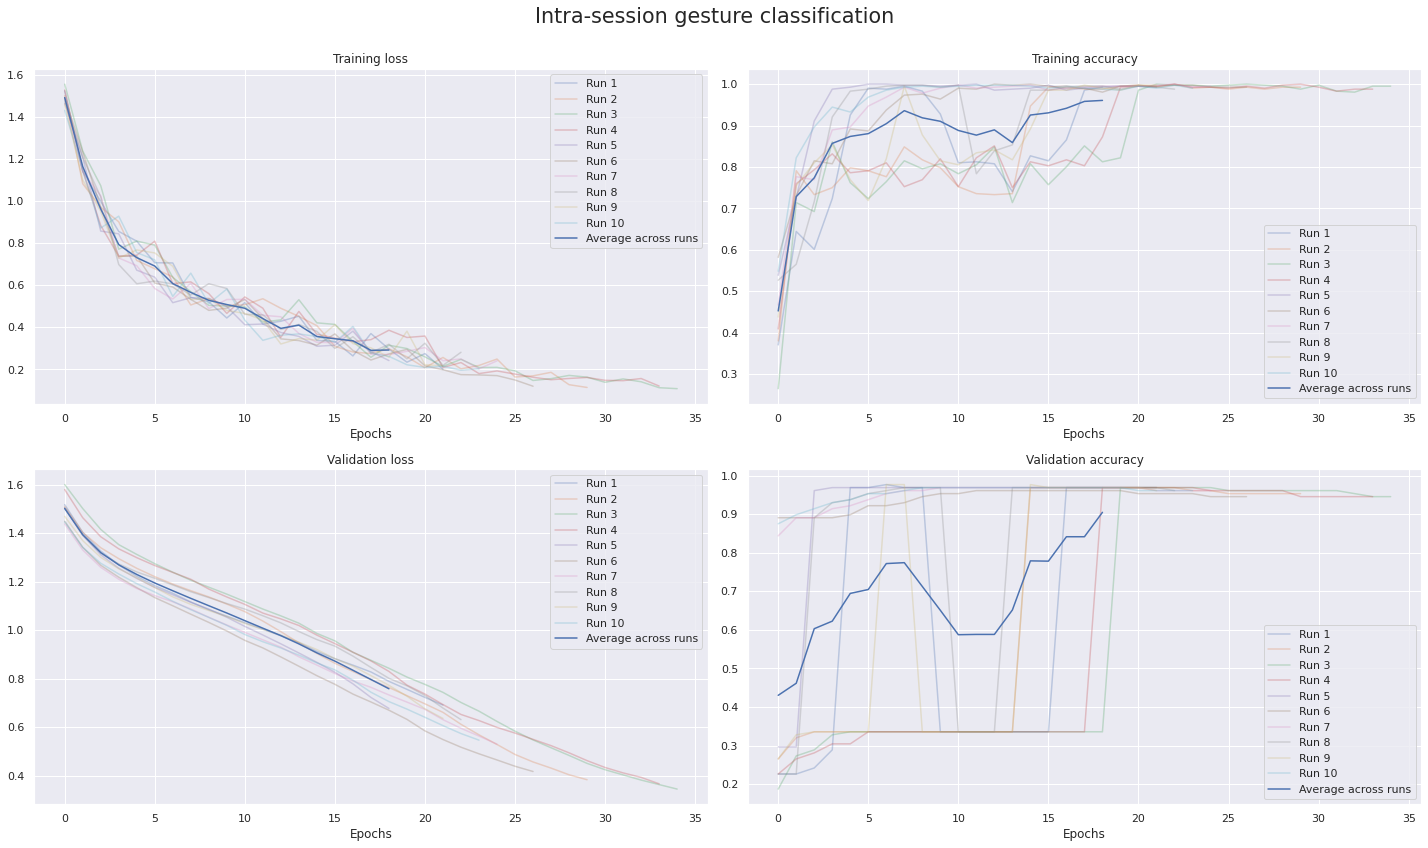

Average test accuracy: 95.82%
Average test accuracy (balanced): 93.50%


In [20]:
hist = {}
test_acc = []
test_acc_b = []
for r in range(10):
    # Create classifier
    clf = semg_bss.clf.MUAPTClassifierMLP(
        n_in=X_train.shape[1],
        n_out=5,
        hidden_struct=(32,),
    ).to(dev)  # move to GPU, if available
    
    # Define criterion
    criterion = nn.CrossEntropyLoss()
    # Define optimizer
    optimizer = optim.Adam(clf.parameters(), weight_decay=1e-4)
    # Define checkpoint file
    checkpoint_path = os.path.join("mlp_models", "mlp_intra.pt")
    # Scaler for AMP
    scaler = GradScaler()

    # Train model
    hist[r] = semg_bss.clf.training_loop(
        clf,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs=50,
        device=dev,
        scaler=scaler,
        checkpoint_path=checkpoint_path,
        early_stopping="val_accuracy",
        patience=15,
        delta=0
    )
    
    # Test it
    y_pred_test = np.zeros_like(y_test)
    for i in range(X_test.shape[0]):
        y_pred_test[i] = semg_bss.clf.inference(
            clf,
            x=torch.Tensor(X_test[i]).to(dev),
            device=dev
        )
    cur_test_acc = accuracy_score(y_test, y_pred_test)
    cur_test_acc_b = balanced_accuracy_score(y_test, y_pred_test, sample_weight=test_weights)
    print(f"Run {r + 1} - Test accuracy: {cur_test_acc:.2%} - Test accuracy (balanced): {cur_test_acc_b:.2%}")
    test_acc.append(cur_test_acc)
    test_acc_b.append(cur_test_acc_b)
    
    clf = clf.cpu()  # move back to CPU

semg_bss.plt.plot_classifier_hist(hist, True, title="Intra-session gesture classification", fig_size=(20, 12))

print(f"Average test accuracy: {sum(test_acc) / len(test_acc):.2%}")
print(f"Average test accuracy (balanced): {sum(test_acc_b) / len(test_acc_b):.2%}")

Let's examine the complexity of the model and re-train it one last time.

In [21]:
# Create classifier
clf = semg_bss.clf.MUAPTClassifierMLP(
    n_in=X_train.shape[1],
    n_out=5,
    hidden_struct=(32,),
).to(dev)  # move to GPU, if available

# Print summary
summary(clf, input_size=(X_train.shape[1],))

# Define criterion
criterion = nn.CrossEntropyLoss()
# Define optimizer
optimizer = optim.Adam(clf.parameters(), weight_decay=1e-4)
# Define checkpoint file
checkpoint_path = os.path.join("mlp_models", "mlp_intra.pt")
# Scaler for AMP
scaler = GradScaler()

# Train model
_ = semg_bss.clf.training_loop(
    clf,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=50,
    device=dev,
    scaler=scaler,
    checkpoint_path=checkpoint_path,
    early_stopping="val_accuracy",
    patience=15,
    delta=0
)

# Test it
y_pred_test = np.zeros_like(y_test)
for i in range(X_test.shape[0]):
    y_pred_test[i] = semg_bss.clf.inference(
        clf,
        x=torch.Tensor(X_test[i]).to(dev),
        device=dev
    )
cur_test_acc = accuracy_score(y_test, y_pred_test)
cur_test_acc_b = balanced_accuracy_score(y_test, y_pred_test, sample_weight=test_weights)
print(f"Run {r + 1} - Test accuracy: {cur_test_acc:.2%} - Test accuracy (balanced): {cur_test_acc_b:.2%}")

clf = clf.cpu()  # move back to CPU

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]       1,216,032
              ReLU-2                   [-1, 32]               0
            Linear-3                    [-1, 5]             165
Total params: 1,216,197
Trainable params: 1,216,197
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.14
Forward/backward pass size (MB): 0.00
Params size (MB): 4.64
Estimated Total Size (MB): 4.78
----------------------------------------------------------------
Run 10 - Test accuracy: 95.98% - Test accuracy (balanced): 93.75%


## 3b. Classification with MLP-200 (intra-session)
Let's prepare the training data for the classification task: we'll use 200 ms-long slices from each contraction. To avoid data leakage, the test set will include the 2nd repetition of each gesture, since they weren't used for calibration.

In [22]:
slice_len = 0.2  # = 200 ms
step_len = 0.05  # = 50 ms

# Matrix associated with rest
rest_mtx = np.zeros(
    shape=(1, emg_separator.n_mu * int(slice_len * FS_EMG)),
    dtype=np.int8
)

# Gesture dict
gestures = ["rest", "hand_open", "fist", "index", "ok"]
gesture_dict = {g: i for i, g in enumerate(gestures)}
inv_gesture_dict = {i: g for i, g in enumerate(gestures)}

# Output matrices
X_trainval = np.zeros(shape=(0, emg_separator.n_mu * int(slice_len * FS_EMG)))
y_trainval = np.zeros(shape=(0,), dtype=np.int8)
X_test = np.zeros(shape=(0, emg_separator.n_mu * int(slice_len * FS_EMG)))
y_test = np.zeros(shape=(0,), dtype=np.int8)

# Iterate over gestures
for gesture in gestures:
    g_labels = [(idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture]
    # Iterate over gesture repetitions
    for i, (g_from, g_to) in enumerate(g_labels):
        # Extract gesture and decompose it
        g_slice = emg[:, g_from:g_to]
        firings = emg_separator.decompose(g_slice)
        
        # Iterate over slices
        start = 0
        stop = (g_to - g_from) / FS_EMG
        while start < stop - slice_len:
            if gesture != "rest":  # contraction
                if firings.empty:  # unexpected empty firings during contraction
                    print(f"MU extraction failed on segment {i + 1} of gesture {gesture}.")
                    break
                else:  # expected non-empty firings during contraction
                    # Slice firings
                    cur_firings = firings[(firings["Firing time"] >= start) & (firings["Firing time"] < start + slice_len)]
                    if i != 1:  # train/val
                        X_trainval = np.concatenate([
                            X_trainval,
                            semg_bss.clf.df_to_dense(
                                cur_firings,
                                emg_separator.n_mu,
                                offset=start,
                                sig_len=slice_len,
                                fs=FS_EMG
                            ).flatten().reshape(1, -1)
                        ])
                        y_trainval = np.concatenate([y_trainval, (gesture_dict[gesture],)])
                    else:  # test
                        X_test = np.concatenate([
                            X_test,
                            semg_bss.clf.df_to_dense(
                                cur_firings,
                                emg_separator.n_mu,
                                offset=start,
                                sig_len=slice_len,
                                fs=FS_EMG
                            ).flatten().reshape(1, -1)
                        ])
                        y_test = np.concatenate([y_test, (gesture_dict[gesture],)])
                    start += step_len
            
            else:  # rest
                if firings.empty:  # expected empty firings during rest state
                    if i not in [1, 4, 7, 10, 13]:
                        X_trainval = np.concatenate([X_trainval, rest_mtx])
                        y_trainval = np.concatenate([y_trainval, (gesture_dict["rest"],)])
                    else:
                        X_test = np.concatenate([X_test, rest_mtx])
                        y_test = np.concatenate([y_test, (gesture_dict["rest"],)])
                    start += step_len
                else:  # unexpected non-empty firings during rest state
                    print(f"MUAPTs detected during rest state.")
                    break

# Split trainval in training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

print("Shape of training data:", X_train.shape, y_train.shape)
print("Shape of validation data:", X_val.shape, y_val.shape)
print("Shape of test data:", X_test.shape, y_test.shape)

Shape of training data: (472, 15200) (472,)
Shape of validation data: (118, 15200) (118,)
Shape of test data: (303, 15200) (303,)


Let's plot the sample distributions.

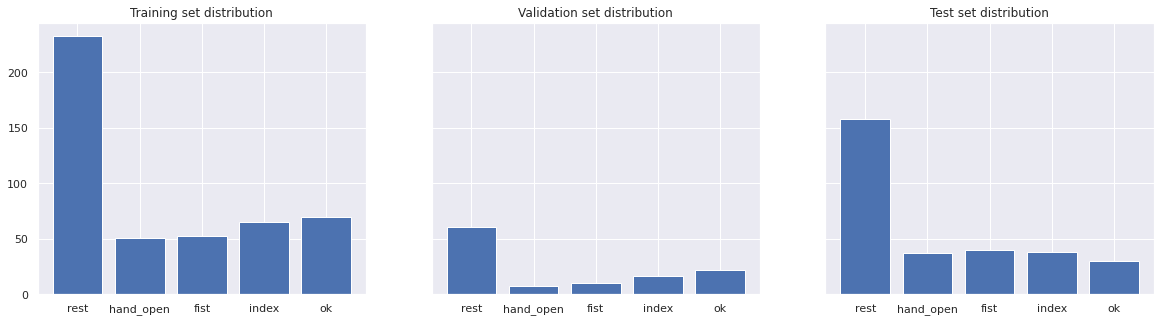

In [23]:
train_count = Counter(y_train)
val_count = Counter(y_val)
test_count = Counter(y_test)

g_range = list(gesture_dict.values())
_, ax = plt.subplots(1, 3, figsize=(20, 5), sharey="all")
ax[0].set_title("Training set distribution")
ax[0].bar(
    x=g_range,
    height=[train_count[g] for g in g_range],
    tick_label=[inv_gesture_dict[g] for g in g_range]
)
ax[1].set_title("Validation set distribution")
ax[1].bar(
    x=g_range,
    height=[val_count[g] for g in g_range],
    tick_label=[inv_gesture_dict[g] for g in g_range]
)
ax[2].set_title("Test set distribution")
ax[2].bar(
    x=g_range,
    height=[test_count[g] for g in g_range],
    tick_label=[inv_gesture_dict[g] for g in g_range]
)
plt.show()

As it can be seen, rest class is far more frequent than the others. Let's correct this by computing a weight score.

In [24]:
train_inv_freq = [X_train.shape[0] / train_count[g] for g in g_range]
test_inv_freq = [X_test.shape[0] / test_count[g] for g in g_range]

train_weights = np.array([train_inv_freq[y] for y in y_train])
test_weights = np.array([test_inv_freq[y] for y in y_test])

Let's create a `DataLoader` for each set, together with a `WeightedRandomSampler`.

In [25]:
# Convert to Torch Dataset
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).long()
train_data = TensorDataset(X_train, y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val).long()
val_data = TensorDataset(X_val, y_val)

# Create sampler
sampler = WeightedRandomSampler(train_weights, num_samples=X_train.shape[0])

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=32, sampler=sampler, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32)

Let's define a simple MLP classifier and train it several times.

Run 1 - Test accuracy: 93.07% - Test accuracy (balanced): 88.95%
Run 2 - Test accuracy: 92.74% - Test accuracy (balanced): 88.42%
Run 3 - Test accuracy: 93.40% - Test accuracy (balanced): 89.47%
Run 4 - Test accuracy: 92.74% - Test accuracy (balanced): 88.42%
Run 5 - Test accuracy: 92.08% - Test accuracy (balanced): 87.42%
Run 6 - Test accuracy: 92.74% - Test accuracy (balanced): 88.42%
Run 7 - Test accuracy: 92.41% - Test accuracy (balanced): 87.92%
Run 8 - Test accuracy: 92.74% - Test accuracy (balanced): 88.42%
Run 9 - Test accuracy: 92.08% - Test accuracy (balanced): 87.42%
Run 10 - Test accuracy: 92.74% - Test accuracy (balanced): 88.42%


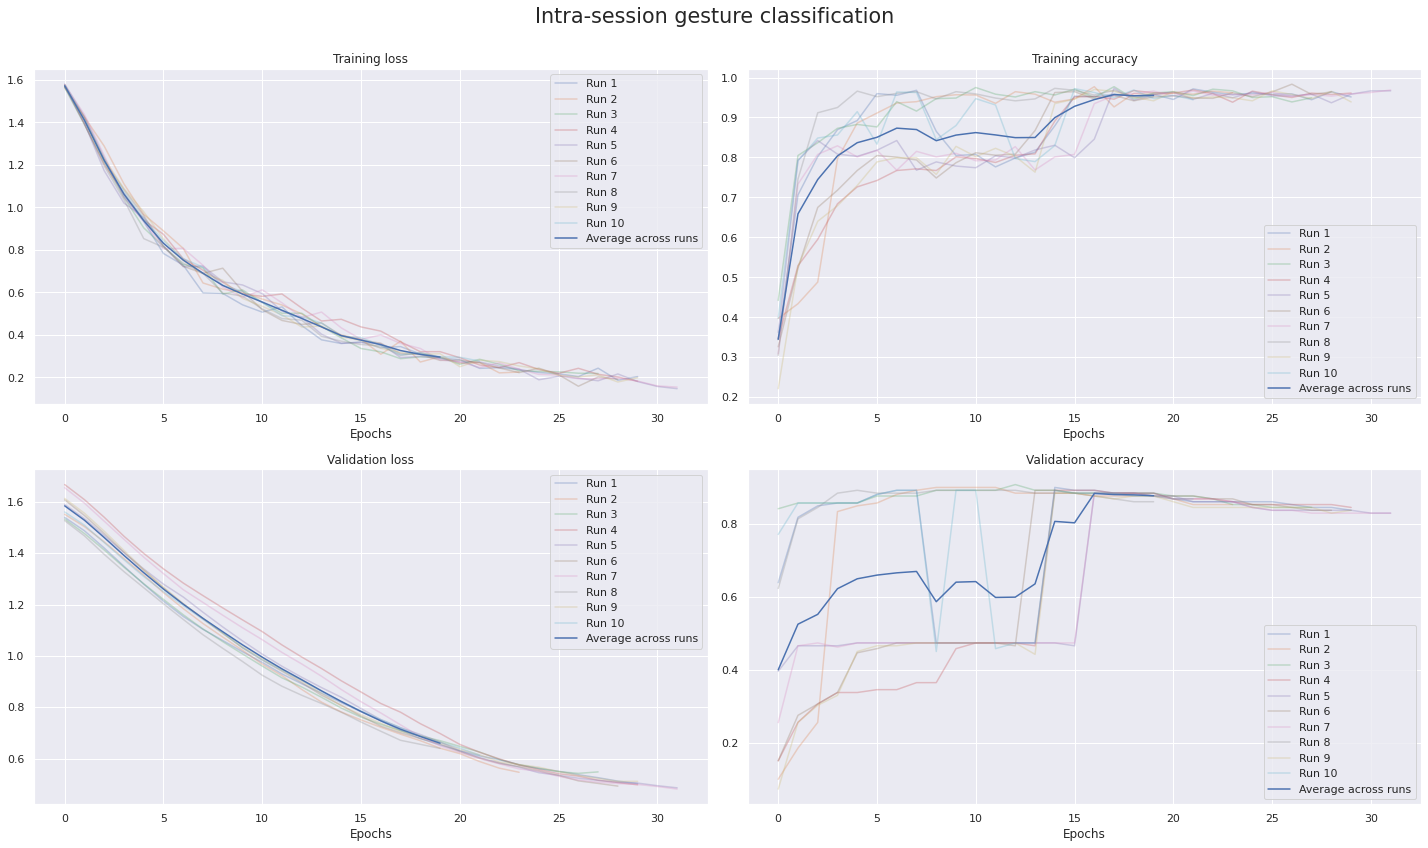

Average test accuracy: 92.67%
Average test accuracy (balanced): 88.33%


In [26]:
hist = {}
test_acc = []
test_acc_b = []
for r in range(10):
    # Create classifier
    clf = semg_bss.clf.MUAPTClassifierMLP(
        n_in=X_train.shape[1],
        n_out=5,
        hidden_struct=(32,),
    ).to(dev)  # move to GPU, if available
    
    # Define criterion
    criterion = nn.CrossEntropyLoss()
    # Define optimizer
    optimizer = optim.Adam(clf.parameters(), weight_decay=1e-4)
    # Define checkpoint file
    checkpoint_path = os.path.join("mlp_models", "mlp_intra.pt")
    # Scaler for AMP
    scaler = GradScaler()

    # Train model
    hist[r] = semg_bss.clf.training_loop(
        clf,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs=50,
        device=dev,
        scaler=scaler,
        checkpoint_path=checkpoint_path,
        early_stopping="val_accuracy",
        patience=15,
        delta=0
    )
    
    # Test it
    y_pred_test = np.zeros_like(y_test)
    for i in range(X_test.shape[0]):
        y_pred_test[i] = semg_bss.clf.inference(
            clf,
            x=torch.Tensor(X_test[i]).to(dev),
            device=dev
        )
    cur_test_acc = accuracy_score(y_test, y_pred_test)
    cur_test_acc_b = balanced_accuracy_score(y_test, y_pred_test, sample_weight=test_weights)
    print(f"Run {r + 1} - Test accuracy: {cur_test_acc:.2%} - Test accuracy (balanced): {cur_test_acc_b:.2%}")
    test_acc.append(cur_test_acc)
    test_acc_b.append(cur_test_acc_b)
    
    clf = clf.cpu()  # move back to CPU

semg_bss.plt.plot_classifier_hist(hist, True, title="Intra-session gesture classification", fig_size=(20, 12))

print(f"Average test accuracy: {sum(test_acc) / len(test_acc):.2%}")
print(f"Average test accuracy (balanced): {sum(test_acc_b) / len(test_acc_b):.2%}")

Let's examine the complexity of the model and re-train it one last time.

In [27]:
# Create classifier
clf = semg_bss.clf.MUAPTClassifierMLP(
    n_in=X_train.shape[1],
    n_out=5,
    hidden_struct=(32,),
).to(dev)  # move to GPU, if available

# Print summary
summary(clf, input_size=(X_train.shape[1],))

# Define criterion
criterion = nn.CrossEntropyLoss()
# Define optimizer
optimizer = optim.Adam(clf.parameters(), weight_decay=1e-4)
# Define checkpoint file
checkpoint_path = os.path.join("mlp_models", "mlp_intra.pt")
# Scaler for AMP
scaler = GradScaler()

# Train model
_ = semg_bss.clf.training_loop(
    clf,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=50,
    device=dev,
    scaler=scaler,
    checkpoint_path=checkpoint_path,
    early_stopping="val_accuracy",
    patience=15,
    delta=0
)

# Test it
y_pred_test = np.zeros_like(y_test)
for i in range(X_test.shape[0]):
    y_pred_test[i] = semg_bss.clf.inference(
        clf,
        x=torch.Tensor(X_test[i]).to(dev),
        device=dev
    )
cur_test_acc = accuracy_score(y_test, y_pred_test)
cur_test_acc_b = balanced_accuracy_score(y_test, y_pred_test, sample_weight=test_weights)
print(f"Run {r + 1} - Test accuracy: {cur_test_acc:.2%} - Test accuracy (balanced): {cur_test_acc_b:.2%}")

clf = clf.cpu()  # move back to CPU

# Save weight and bias
layer = next(clf.children())  # access Sequential layer
mlp1_w = layer[0].state_dict()["weight"].numpy()  # first FC
mlp1_b = layer[0].state_dict()["bias"].numpy()  # first FC
mlp2_w = layer[2].state_dict()["weight"].numpy()  # second FC
mlp2_b = layer[2].state_dict()["bias"].numpy()  # second FC

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]         486,432
              ReLU-2                   [-1, 32]               0
            Linear-3                    [-1, 5]             165
Total params: 486,597
Trainable params: 486,597
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.00
Params size (MB): 1.86
Estimated Total Size (MB): 1.91
----------------------------------------------------------------
Run 10 - Test accuracy: 92.08% - Test accuracy (balanced): 87.37%


## 3c. Classification with DNN (intra-session)
Let's prepare the training data for the classification task: we'll use 200 ms-long slices from each contraction. To avoid data leakage, the test set will include the 2nd repetition of each gesture, since they weren't used for calibration.

In [28]:
slice_len = 0.2  # = 200 ms
step_len = 0.05  # = 50 ms

# Matrix associated with rest
rest_mtx = np.zeros(
    shape=(1, emg_separator.n_mu, int(slice_len * FS_EMG)),
    dtype=np.int8
)

# Gesture dict
gestures = ["rest", "hand_open", "fist", "index", "ok"]
gesture_dict = {g: i for i, g in enumerate(gestures)}
inv_gesture_dict = {i: g for i, g in enumerate(gestures)}

# Output matrices
X_trainval = np.zeros(shape=(0, emg_separator.n_mu, int(slice_len * FS_EMG)))
y_trainval = np.zeros(shape=(0,), dtype=np.int8)
X_test = np.zeros(shape=(0, emg_separator.n_mu, int(slice_len * FS_EMG)))
y_test = np.zeros(shape=(0,), dtype=np.int8)

# Iterate over gestures
for gesture in gestures:
    g_labels = [(idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture]
    # Iterate over gesture repetitions
    for i, (g_from, g_to) in enumerate(g_labels):
        # Extract gesture and decompose it
        g_slice = emg[:, g_from:g_to]
        firings = emg_separator.decompose(g_slice)
        
        # Iterate over slices
        start = 0
        stop = (g_to - g_from) / FS_EMG
        while start < stop - slice_len:
            if gesture != "rest":  # contraction
                if firings.empty:  # unexpected empty firings during contraction
                    print(f"MU extraction failed on segment {i + 1} of gesture {gesture}.")
                    break
                else:  # expected non-empty firings during contraction
                    # Slice firings
                    cur_firings = firings[(firings["Firing time"] >= start) & (firings["Firing time"] < start + slice_len)]
                    if i != 1:  # train/val
                        X_trainval = np.concatenate([
                            X_trainval,
                            np.expand_dims(
                                semg_bss.clf.df_to_dense(
                                    cur_firings,
                                    emg_separator.n_mu,
                                    offset=start,
                                    sig_len=slice_len,
                                    fs=FS_EMG
                                ),
                                axis=0
                            )
                        ])
                        y_trainval = np.concatenate([y_trainval, (gesture_dict[gesture],)])
                    else:  # test
                        X_test = np.concatenate([
                            X_test,
                            np.expand_dims(
                                semg_bss.clf.df_to_dense(
                                    cur_firings,
                                    emg_separator.n_mu,
                                    offset=start,
                                    sig_len=slice_len,
                                    fs=FS_EMG
                                ),
                                axis=0
                            )
                        ])
                        y_test = np.concatenate([y_test, (gesture_dict[gesture],)])
                    start += step_len
            
            else:  # rest
                if firings.empty:  # expected empty firings during rest state
                    if i not in [1, 4, 7, 10, 13]:
                        X_trainval = np.concatenate([X_trainval, rest_mtx])
                        y_trainval = np.concatenate([y_trainval, (gesture_dict["rest"],)])
                    else:
                        X_test = np.concatenate([X_test, rest_mtx])
                        y_test = np.concatenate([y_test, (gesture_dict["rest"],)])
                    start += step_len
                else:  # unexpected non-empty firings during rest state
                    print(f"MUAPTs detected during rest state.")
                    break

# Split trainval in training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

print("Shape of training data:", X_train.shape, y_train.shape)
print("Shape of validation data:", X_val.shape, y_val.shape)
print("Shape of test data:", X_test.shape, y_test.shape)

Shape of training data: (472, 19, 800) (472,)
Shape of validation data: (118, 19, 800) (118,)
Shape of test data: (303, 19, 800) (303,)


Let's plot the sample distributions.

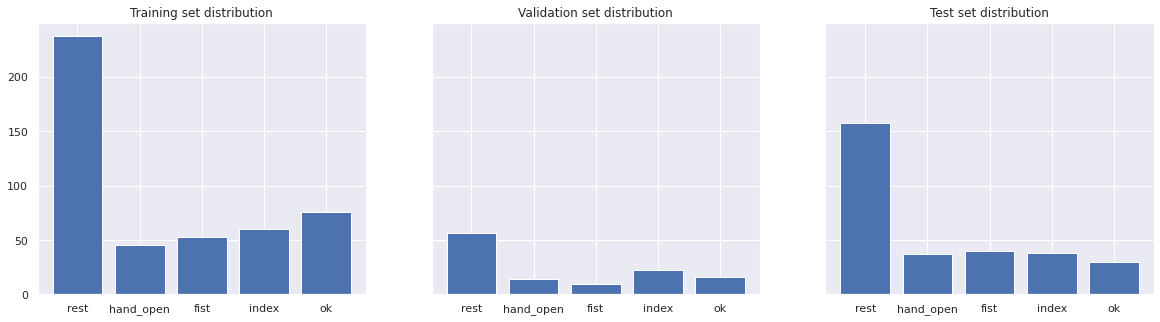

In [29]:
train_count = Counter(y_train)
val_count = Counter(y_val)
test_count = Counter(y_test)

g_range = list(gesture_dict.values())
_, ax = plt.subplots(1, 3, figsize=(20, 5), sharey="all")
ax[0].set_title("Training set distribution")
ax[0].bar(
    x=g_range,
    height=[train_count[g] for g in g_range],
    tick_label=[inv_gesture_dict[g] for g in g_range]
)
ax[1].set_title("Validation set distribution")
ax[1].bar(
    x=g_range,
    height=[val_count[g] for g in g_range],
    tick_label=[inv_gesture_dict[g] for g in g_range]
)
ax[2].set_title("Test set distribution")
ax[2].bar(
    x=g_range,
    height=[test_count[g] for g in g_range],
    tick_label=[inv_gesture_dict[g] for g in g_range]
)
plt.show()

As it can be seen, rest class is far more frequent than the others. Let's correct this by computing a weight score.

In [30]:
train_inv_freq = [X_train.shape[0] / train_count[g] for g in g_range]
test_inv_freq = [X_test.shape[0] / test_count[g] for g in g_range]

train_weights = np.array([train_inv_freq[y] for y in y_train])
test_weights = np.array([test_inv_freq[y] for y in y_test])

Let's create a `DataLoader` for each set, together with a `WeightedRandomSampler`.

In [31]:
# Convert to Torch Dataset
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).long()
train_data = TensorDataset(X_train, y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val).long()
val_data = TensorDataset(X_val, y_val)

# Create sampler
sampler = WeightedRandomSampler(train_weights, num_samples=X_train.shape[0])

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=32, sampler=sampler, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32)

Let's define a classifier with separable temporal and channel aggregation layers and train it several times.

Run 1 - Test accuracy: 95.05% - Test accuracy (balanced): 92.13%
Run 2 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Run 3 - Test accuracy: 95.05% - Test accuracy (balanced): 92.13%
Run 4 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Run 5 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Run 6 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Run 7 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Run 8 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Run 9 - Test accuracy: 95.05% - Test accuracy (balanced): 92.13%
Run 10 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%


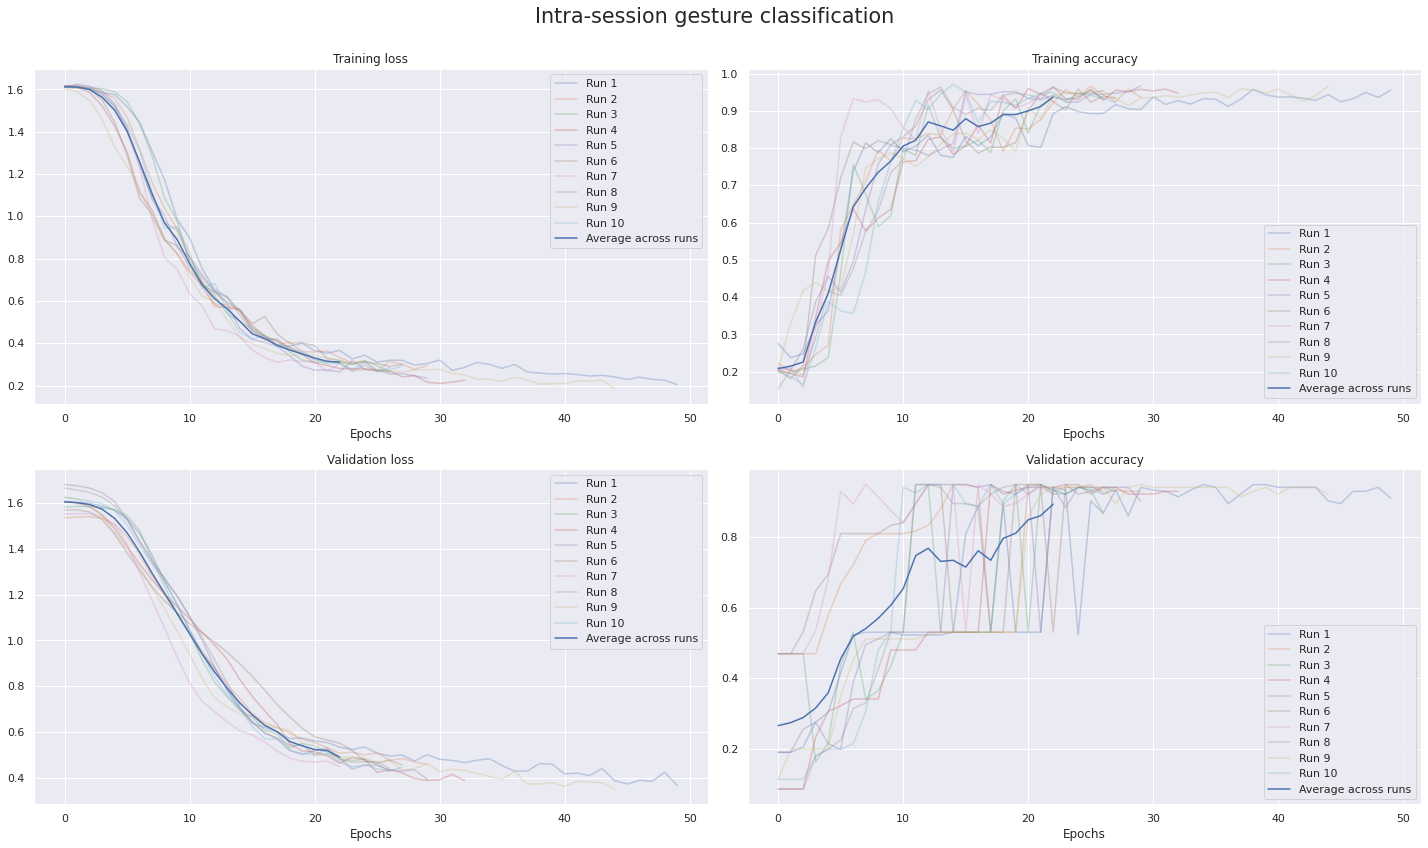

Average test accuracy: 95.28%
Average test accuracy (balanced): 92.48%


In [33]:
hist = {}
test_acc = []
test_acc_b = []
for r in range(10):
    # Create classifier
    clf = semg_bss.clf.MUAPTClassifierDNN(
        in_shape=(emg_separator.n_mu, int(slice_len * FS_EMG)),
        n_ta=4,
        n_ca=16,
        n_out=5
    ).to(dev)  # move to GPU, if available
    
    # Define criterion
    criterion = nn.CrossEntropyLoss()
    # Define optimizer
    optimizer = optim.Adam(clf.parameters(), weight_decay=1e-2)
    # Define checkpoint file
    checkpoint_path = os.path.join("mlp_models", "mlp_intra.pt")
    # Scaler for AMP
    scaler = GradScaler()

    # Train model
    hist[r] = semg_bss.clf.training_loop(
        clf,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs=50,
        device=dev,
        scaler=scaler,
        checkpoint_path=checkpoint_path,
        early_stopping="val_accuracy",
        patience=15,
        delta=0
    )
    
    # Test it
    y_pred_test = np.zeros_like(y_test)
    for i in range(X_test.shape[0]):
        y_pred_test[i] = semg_bss.clf.inference(
            clf,
            x=torch.Tensor(X_test[i]).to(dev),
            device=dev
        )
    cur_test_acc = accuracy_score(y_test, y_pred_test)
    cur_test_acc_b = balanced_accuracy_score(y_test, y_pred_test, sample_weight=test_weights)
    print(f"Run {r + 1} - Test accuracy: {cur_test_acc:.2%} - Test accuracy (balanced): {cur_test_acc_b:.2%}")
    test_acc.append(cur_test_acc)
    test_acc_b.append(cur_test_acc_b)
    
    clf = clf.cpu()  # move back to CPU

semg_bss.plt.plot_classifier_hist(hist, True, title="Intra-session gesture classification", fig_size=(20, 12))

print(f"Average test accuracy: {sum(test_acc) / len(test_acc):.2%}")
print(f"Average test accuracy (balanced): {sum(test_acc_b) / len(test_acc_b):.2%}")

Let's examine the complexity of the model.

In [34]:
clf = semg_bss.clf.MUAPTClassifierDNN(
    in_shape=(emg_separator.n_mu, int(slice_len * FS_EMG)),
    n_ta=4,
    n_ca=16,
    n_out=5
).to(dev)  # move to GPU, if available

# Print summary
summary(clf, input_size=(emg_separator.n_mu, int(slice_len * FS_EMG)))

# Define criterion
criterion = nn.CrossEntropyLoss()
# Define optimizer
optimizer = optim.Adam(clf.parameters(), weight_decay=1e-2)
# Define checkpoint file
checkpoint_path = os.path.join("mlp_models", "mlp_intra.pt")
# Scaler for AMP
scaler = GradScaler()

# Train model
_ = semg_bss.clf.training_loop(
    clf,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=50,
    device=dev,
    scaler=scaler,
    checkpoint_path=checkpoint_path,
    early_stopping="val_accuracy",
    patience=15,
    delta=0
)

# Test it
y_pred_test = np.zeros_like(y_test)
for i in range(X_test.shape[0]):
    y_pred_test[i] = semg_bss.clf.inference(
        clf,
        x=torch.Tensor(X_test[i]).to(dev),
        device=dev
    )
cur_test_acc = accuracy_score(y_test, y_pred_test)
cur_test_acc_b = balanced_accuracy_score(y_test, y_pred_test, sample_weight=test_weights)
print(f"Run {r + 1} - Test accuracy: {cur_test_acc:.2%} - Test accuracy (balanced): {cur_test_acc_b:.2%}")

clf = clf.cpu()  # move back to CPU

# Save weight and bias
layers = clf.children()
layer = next(layers)  # access first Sequential
dnn1_w = layer[0].state_dict()["weight"].numpy()
dnn1_b = layer[0].state_dict()["bias"].numpy()
layer = next(layers)  # access second Sequential
dnn2_w = layer[0].state_dict()["weight"].numpy()
dnn2_b = layer[0].state_dict()["bias"].numpy()
layer = next(layers)  # access last FC
dnn3_w = layer.state_dict()["weight"].numpy()
dnn3_b = layer.state_dict()["bias"].numpy()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 19, 4]           3,204
              ReLU-2                [-1, 19, 4]               0
            Linear-3                   [-1, 16]           1,232
              ReLU-4                   [-1, 16]               0
            Linear-5                    [-1, 5]              85
Total params: 4,521
Trainable params: 4,521
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.08
----------------------------------------------------------------
Run 10 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%


## 3c. Classification with SVM (intra-session)
Let's prepare the training data for the classification task: we'll use 200 ms-long slices from each contraction and count the number of spikes for each MU. To avoid data leakage, the test set will include the 2nd repetition of each gesture, since they weren't used for calibration.

In [35]:
slice_len = 0.2  # = 200 ms
step_len = 0.05  # = 50 ms

# Matrix associated with rest
rest_count = np.zeros(
    shape=(1, emg_separator.n_mu),
    dtype=np.int8
)

# Gesture dict
gestures = ["rest", "hand_open", "fist", "index", "ok"]
gesture_dict = {g: i for i, g in enumerate(gestures)}
inv_gesture_dict = {i: g for i, g in enumerate(gestures)}

# Output matrices
X_train = np.zeros(shape=(0, emg_separator.n_mu))
y_train = np.zeros(shape=(0,), dtype=np.int8)
X_test = np.zeros(shape=(0, emg_separator.n_mu))
y_test = np.zeros(shape=(0,), dtype=np.int8)

# Iterate over gestures
for gesture in gestures:
    g_labels = [(idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture]
    # Iterate over gesture repetitions
    for i, (g_from, g_to) in enumerate(g_labels):
        # Extract gesture and decompose it
        g_slice = emg[:, g_from:g_to]
        firings = emg_separator.decompose(g_slice)
        
        # Iterate over slices
        start = 0
        stop = (g_to - g_from) / FS_EMG
        while start < stop - slice_len:
            if gesture != "rest":  # contraction
                if firings.empty:  # unexpected empty firings during contraction
                    print(f"MU extraction failed on segment {i + 1} of gesture {gesture}.")
                    break
                else:  # expected non-empty firings during contraction
                    # Slice firings
                    cur_firings = firings[(firings["Firing time"] >= start) & (firings["Firing time"] < start + slice_len)]
                    if i != 1:  # train/val
                        X_train = np.concatenate([
                            X_train,
                            semg_bss.clf.df_to_dense(
                                cur_firings,
                                emg_separator.n_mu,
                                offset=start,
                                sig_len=slice_len,
                                fs=FS_EMG
                            ).sum(axis=1).reshape(1, -1)
                        ])
                        y_train = np.concatenate([y_train, (gesture_dict[gesture],)])
                    else:  # test
                        X_test = np.concatenate([
                            X_test,
                            semg_bss.clf.df_to_dense(
                                cur_firings,
                                emg_separator.n_mu,
                                offset=start,
                                sig_len=slice_len,
                                fs=FS_EMG
                            ).sum(axis=1).flatten().reshape(1, -1)
                        ])
                        y_test = np.concatenate([y_test, (gesture_dict[gesture],)])
                    start += step_len
            
            else:  # rest
                if firings.empty:  # expected empty firings during rest state
                    if i not in [1, 4, 7, 10, 13]:
                        X_train = np.concatenate([X_train, rest_count])
                        y_train = np.concatenate([y_train, (gesture_dict["rest"],)])
                    else:
                        X_test = np.concatenate([X_test, rest_count])
                        y_test = np.concatenate([y_test, (gesture_dict["rest"],)])
                    start += step_len
                else:  # unexpected non-empty firings during rest state
                    print(f"MUAPTs detected during rest state.")
                    break

# Split trainval in training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

print("Shape of training data:", X_train.shape, y_train.shape)
# print("Shape of validation data:", X_val.shape, y_val.shape)
print("Shape of test data:", X_test.shape, y_test.shape)

Shape of training data: (590, 19) (590,)
Shape of test data: (303, 19) (303,)


Let's plot the sample distributions.

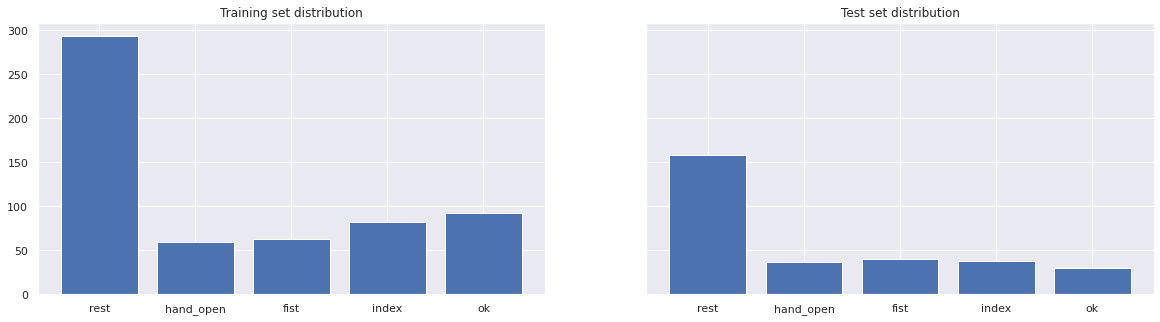

In [36]:
train_count = Counter(y_train)
test_count = Counter(y_test)

g_range = list(gesture_dict.values())
_, ax = plt.subplots(1, 2, figsize=(20, 5), sharey="all")
ax[0].set_title("Training set distribution")
ax[0].bar(
    x=g_range,
    height=[train_count[g] for g in g_range],
    tick_label=[inv_gesture_dict[g] for g in g_range]
)
ax[1].set_title("Test set distribution")
ax[1].bar(
    x=g_range,
    height=[test_count[g] for g in g_range],
    tick_label=[inv_gesture_dict[g] for g in g_range]
)
plt.show()

As it can be seen, rest class is far more frequent than the others. Let's correct this by computing a weight score.

In [37]:
train_inv_freq = [X_train.shape[0] / train_count[g] for g in g_range]
test_inv_freq = [X_test.shape[0] / test_count[g] for g in g_range]

train_weights = np.array([train_inv_freq[y] for y in y_train])
test_weights = np.array([test_inv_freq[y] for y in y_test])

Let's train several SVMs.

In [38]:
from sklearn.svm import SVC

test_acc = []
test_acc_b = []
for r in range(10):
    clf = SVC(kernel="linear")
    # Train
    clf.fit(X_train, y_train, sample_weight=train_weights)
    # Evaluate
    cur_test_acc = clf.score(X_test, y_test)
    cur_test_acc_b = clf.score(X_test, y_test, sample_weight=test_weights)
    print(f"Run {r + 1} - Test accuracy: {cur_test_acc:.2%} - Test accuracy (balanced): {cur_test_acc_b:.2%}")
    test_acc.append(cur_test_acc)
    test_acc_b.append(cur_test_acc_b)
    
print(f"Average test accuracy: {sum(test_acc) / len(test_acc):.2%}")
print(f"Average test accuracy (balanced): {sum(test_acc_b) / len(test_acc_b):.2%}")

Run 1 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Run 2 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Run 3 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Run 4 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Run 5 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Run 6 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Run 7 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Run 8 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Run 9 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Run 10 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%
Average test accuracy: 95.38%
Average test accuracy (balanced): 92.63%


In [39]:
clf = SVC(kernel="linear")
# Train
clf.fit(X_train, y_train, sample_weight=train_weights)
# Evaluate
cur_test_acc = clf.score(X_test, y_test)
cur_test_acc_b = clf.score(X_test, y_test, sample_weight=test_weights)
print(f"Run {r + 1} - Test accuracy: {cur_test_acc:.2%} - Test accuracy (balanced): {cur_test_acc_b:.2%}")

Run 10 - Test accuracy: 95.38% - Test accuracy (balanced): 92.63%


## 4. Export model (C source)
We must write all the necessary parameters into a C file readable by PULP.

In [16]:
with open("separator.c", mode="w") as f:
    f.write("#include \"../include/separator.h\"\n\n")
    f.write(f"PI_L2 float mean_vec_data[] = {{{', '.join([f'{n}f' for n in emg_separator._params.mean_vec.flatten()])}}};\n")
    f.write("\n")
    f.write(f"PI_L2 float white_mtx_data[] = {{{', '.join([f'{n}f' for n in emg_separator._params.white_mtx.flatten()])}}};\n")
    f.write("\n")
    f.write(f"PI_L2 float sep_mtx_data[] = {{{', '.join([f'{n}f' for n in emg_separator._params.sep_mtx.flatten()])}}};\n")
    f.write("\n")
    f.write(f"PI_L2 float spike_th_data[] = {{{', '.join([f'{n}f' for n in emg_separator._params.spike_th.flatten()])}}};\n")

In [ ]:
with open("dnn.c", mode="w") as f:
    f.write("#include \"../include/dnn.h\"\n\n")
    f.write(f"PI_L2 float dnn1_w_data[] = {{{', '.join([f'{n}f' for n in dnn1_w.flatten()])}}};\n")
    f.write("\n")
    f.write(f"PI_L2 float dnn1_b_data[] = {{{', '.join([f'{n}f' for n in dnn1_b.flatten()])}}};\n")
    f.write("\n")
    f.write(f"PI_L2 float dnn2_w_data[] = {{{', '.join([f'{n}f' for n in dnn2_w.flatten()])}}};\n")
    f.write("\n")
    f.write(f"PI_L2 float dnn2_b_data[] = {{{', '.join([f'{n}f' for n in dnn2_b.flatten()])}}};\n")
    f.write("\n")
    f.write(f"PI_L2 float dnn3_w_data[] = {{{', '.join([f'{n}f' for n in dnn3_w.flatten()])}}};\n")
    f.write("\n")
    f.write(f"PI_L2 float dnn3_b_data[] = {{{', '.join([f'{n}f' for n in dnn3_b.flatten()])}}};\n")

In [ ]:
with open("svm.c", mode="w") as f:
    f.write("#include \"../include/svm.h\"\n\n")
    f.write(f"PI_L2 float svm_coef_data[] = {{{', '.join([f'{n}f' for n in clf.coef_.flatten()])}}};\n")
    f.write("\n")
    f.write(f"PI_L2 float svm_intercept_data[] = {{{', '.join([f'{n}f' for n in clf.intercept_.flatten()])}}};\n")

Then, we must create a test signal.

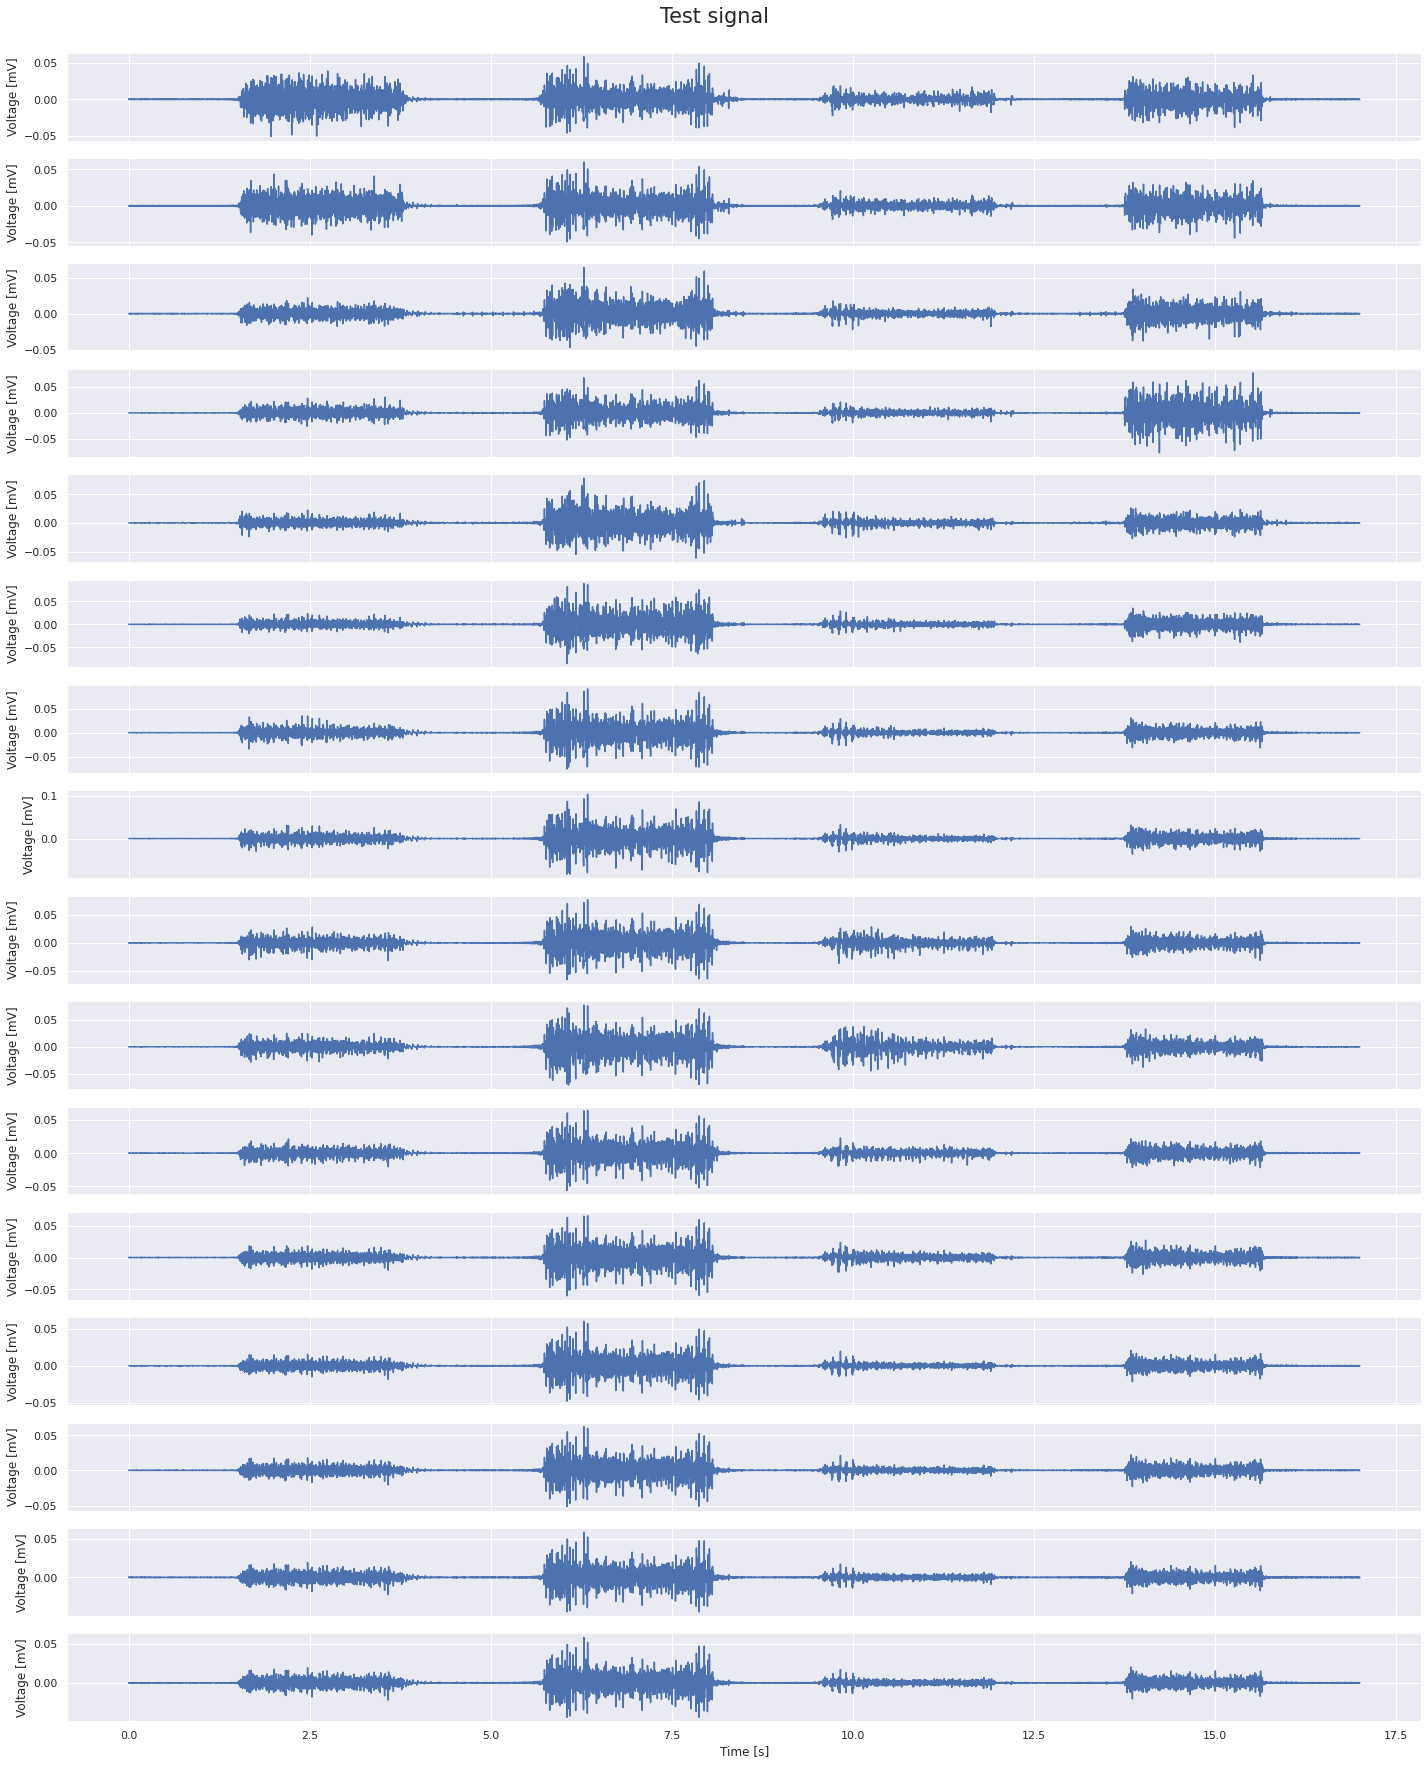

In [16]:
idx_from = int(3 * FS_EMG)
idx_to = int(7.5 * FS_EMG)
tmp1 = emg1[:, idx_from:idx_to]
idx_from = int(16 * FS_EMG)
idx_to = int(20 * FS_EMG)
tmp2 = emg1[:, idx_from:idx_to]
idx_from = int(29.5 * FS_EMG)
idx_to = int(34 * FS_EMG)
tmp3 = emg1[:, idx_from:idx_to]
idx_from = int(44 * FS_EMG)
idx_to = int(48 * FS_EMG)
tmp4 = emg1[:, idx_from:idx_to]

emg_test = np.hstack([tmp1, tmp2, tmp3, tmp4])
semg_bss.plt.plot_signal(
    emg_test,
    fs=FS_EMG,
    title="Test signal",
    fig_size=(20, 25)
)

with open("data.c", mode="w") as f:
    f.write("#include \"../include/data.h\"\n\n")
    f.write(f"size_t emg_height = {emg_test.shape[0]};\n")
    f.write(f"size_t emg_width = {emg_test.shape[1]};\n")
    f.write(f"PI_L2 float emg_data[] = {{{', '.join([f'{n}f' for n in emg_test.flatten()])}}};")

In [43]:
gestures = ["rest", "hand_open", "fist", "index", "ok"]
for gesture in gestures:
    g_from, _ = next((idx_from, idx_to) for label, idx_from, idx_to in labels if label == gesture)
    
    start = g_from + int(0.1 * FS_EMG)
    stop = start + int(0.2 * FS_EMG)
    emg_slice = emg[:, start:stop]
    
    # Write header
    with open(f"{gesture}.h", mode="w") as f:
        f.write(f"#ifndef {gesture.upper()}_H\n")
        f.write(f"#define {gesture.upper()}_H\n\n")
        f.write("#include \"pmsis.h\"\n\n")
        f.write("PI_L2 extern float emg_data[];\n\n")
        f.write("#endif")
    
    # Write source
    with open(f"{gesture}.c", mode="w") as f:
        f.write(f"#include \"../include/{gesture}.h\"\n\n")
        f.write(f"PI_L2 float emg_data[] = {{{', '.join([f'{n}f' for n in emg_slice.flatten(order='F')])}}};")